# Follow-up intron diversity

## Setup

In [1]:

#QUESTION: DO WE ACTUALLY WANT TO USE THE WHOLE CALLSET OR THE PASSED CALLSET? THE METHOD INHERENTLY REPORTS
#DIVERSITY FOR EVERY ACCESSIBLE POSITION, SO BY USING ONLY THE PASS CALLSETS, WE ARE STILL MAKING A STATEMENT 
#ABOUT FILTER-FAILING POSITIONS (STATING THAT THERE IS NO DIVERSITY THERE). IT SEEMS TO ME THAT IT THEREFORE 
#MAKES MORE SENSE TO USE ALL SNPS, BUT ALISTAIR'S ORIGINAL NOTEBOOK USES AN OBJECT CALLED callset_pass, SO I 
#ASSUMED THAT IT WAS USING THE PASS SNPS ONLY. 

THERE IS AN ISSUE BECAUSE THE WAY IN WHICH CODING POSITION IS CURRENTLY DEFINED (BY MODULUS OF POSITION 
TO CDS START POINT) ONLY WORKS FOR THE FIRST EXON. AFTER THAT, THE START POINT IS THE INTRON-EXON BOUNDARY,
WHICH DOES NOT NECESSARILY CORRESPOND TO THE START OF A CODON

import sys
import petl as etl
import petlx.bio
import numpy as np
import functools
import allel
import pandas as pd
sys.path.insert(0, '../../agam-report-base/src/python')
from util import *
from ag1k import phase2_ar1
phase2_ar1.init("../../phase2.AR1")
genome = phase2_ar1.genome_agamp4
accessibility = phase2_ar1.accessibility
allele_counts = phase2_ar1.allele_counts
callset = phase2_ar1.callset
callset_pass = phase2_ar1.callset_pass

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
# use seaborn defaults
rcParams = plt.rcParams
rcParams['savefig.jpeg_quality'] = 100
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}

In [3]:
# Having a guess at what Alistair's "get_features" function does
def get_features(chrom):
    return get_geneset_features(phase2_ar1.geneset_agamp44_fn, chrom)

In [4]:
CLS_UPSTREAM = 1
CLS_5UTR = 2
CLS_EXON_FIRST = 3
CLS_INTRON_FIRST = 4
CLS_EXON_MID = 5
CLS_INTRON_LAST = 6
CLS_EXON_LAST = 7
CLS_3UTR = 8
CLS_DOWNSTREAM = 9
CLS_INTRON_MID = 10


# Made an addition to Alistair's code to also return a "feature code" for each intronic or exonic position
# to record which exon or intron they belong to (ie: all positions from the same exon will have the same
# feature code))
def compute_features(chrom):
    log('compute features', chrom)

    # extract features
    ###################
    
    tbl_features = (
        get_features(chrom)
        .convert('start', lambda v: v-1)
        .rename('end', 'stop')
        .unpackdict('attributes', ['Parent', 'ID'])
        .rename('Parent', 'parent')
        .addfield('length', lambda rec: rec.stop-rec.start, index=5)
        .cache()
    )
    
    # obtain genes
    ###############
    
    tbl_genes = tbl_features.eq('type', 'gene')    

    # obtain CDSs
    ##############
    
    def child_first(prv, cur, nxt):
        return (
            (cur.strand == '+' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '-') and (nxt is None or cur.parent != nxt.parent)
        )

    def child_last(prv, cur, nxt):
        return (
            (cur.strand == '-' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '+') and (nxt is None or cur.parent != nxt.parent)
        )

    tbl_cdss = (
        tbl_features
        .eq('type', 'CDS')
        .select('parent', lambda v: v.endswith('RA'))
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )    

    # obtain introns
    #################
    
    def cds2intron(parent, cdss):
        cdss = list(cdss)
        seqid = cdss[0].seqid
        strand = cdss[0].strand
        type = 'intron'
        for i in range(1, len(cdss)):
            start = cdss[i-1].stop
            stop = cdss[i].start
            yield (seqid, type, start, stop, stop-start, strand, parent)

    tbl_introns = (
        tbl_cdss
        .rowgroupmap(key='parent', mapper=cds2intron, header=['seqid', 'type', 'start', 'stop', 'length', 'strand', 'parent'])
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )
    
    # setup outputs
    ################
    
    seq = np.asarray(genome[chrom])
    seq_cls = np.zeros(seq.size, dtype='u1')
    seq_relpos = np.zeros(seq.size, dtype='u4')
    seq_relpos_end = np.zeros(seq.size, dtype='u4')
    seq_flen = np.zeros(seq.size, dtype='u4')
    # These final values will specifically be used for comparing mean diversity with that found in the
    # dsx gene
    seq_intron_group = np.zeros(seq.size, dtype='u4')
    seq_exon_group = np.zeros(seq.size, dtype='u4')

    # build the upstream and downstream classes
    ############################################
    
    prv_gene = None
    for gene in tbl_genes.records():

        if prv_gene is not None and (gene.start - prv_gene.stop) > 1000:

            # midpoint between previous and current genes
            m = (prv_gene.stop + gene.start) // 2

            # deal with previous gene
            if prv_gene.strand == '+':
                prv_cls = CLS_DOWNSTREAM
            else:
                prv_cls = CLS_UPSTREAM
            seq_cls[prv_gene.stop:m] = prv_cls
            seq_relpos[prv_gene.stop:m] = np.arange(m - prv_gene.stop)
            seq_relpos_end[prv_gene.stop:m] = np.arange(m - prv_gene.stop)[::-1]
            seq_flen[prv_gene.stop:m] = m - prv_gene.stop
            
            # deal with current gene
            if gene.strand == '+':
                cls = CLS_UPSTREAM
            else:
                cls = CLS_DOWNSTREAM
            seq_cls[m:gene.start] = cls
            seq_relpos[m:gene.start] = np.arange(gene.start - m)[::-1]
            seq_relpos_end[m:gene.start] = np.arange(gene.start - m)
            seq_flen[m:gene.start] = gene.start - m

        prv_gene = gene

    # build the UTR classes
    ########################
    
    for f in tbl_features.records():

        cls = None
        if f['type'] == 'five_prime_UTR':
            cls = CLS_5UTR
        elif f['type'] == 'three_prime_UTR':
            cls = CLS_3UTR

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the exon classes
    #########################
    
    exon_counter_value = 100000    
    for f in tbl_cdss.records():
        
        cls = None
        if f.first and not f.last:
            cls = CLS_EXON_FIRST
        elif not f.first and f.last:
            cls = CLS_EXON_LAST
        elif not f.first and not f.last:
            cls = CLS_EXON_MID

        if cls:
            exon_counter_value += 1
            seq_exon_group[f.start:f.stop] = exon_counter_value
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the intron classes
    ###########################
    
    intron_counter_value = 0
    for f in tbl_introns.records():

        cls = None
        if f.first and not f.last:
            cls = CLS_INTRON_FIRST
        elif not f.first and f.last:
            cls = CLS_INTRON_LAST
        elif not f.first and not f.last:
            cls = CLS_INTRON_MID

        if cls:
            intron_counter_value += 1
            seq_intron_group[f.start:f.stop] = intron_counter_value
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start

    return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_exon_group, seq_intron_group


@functools.lru_cache(maxsize=None)
def compute_feature_diversity(chrom, pop='all', filter_acc = True, return_groups = False):
    log('compute feature diversity', chrom, pop)
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_exon_group, seq_intron_group = compute_features(chrom)
    
    # compute mean pairwise difference
    ###################################
    
    seq_mpd = np.zeros(seq_cls.size, dtype='f8')
    filter_pass = phase2_ar1.callset[chrom]['variants/FILTER_PASS']
    ac = allel.AlleleCountsArray(allele_counts[chrom][pop])[filter_pass,:]
    mpd = allel.mean_pairwise_difference(ac)
    pos = callset_pass[chrom]['variants/POS'][:]
    seq_mpd[pos-1] = mpd
    
    # compute watterson's theta
    ############################
    
    seq_wt = np.zeros(seq_cls.size, dtype='f8')
    is_seg = ac.is_segregating().astype('f8')
    n = ac.sum(axis=1).max()
    wt = is_seg / np.sum(1 / np.arange(1, n))
    seq_wt[pos-1] = wt
    
    # filter for accessibility
    ###########################
    
    if filter_acc:
        is_accessible = accessibility[chrom]['is_accessible'][:]
        seq_cls = seq_cls[is_accessible]
        seq_relpos = seq_relpos[is_accessible]
        seq_relpos_end = seq_relpos_end[is_accessible]
        seq_flen = seq_flen[is_accessible]
        seq_mpd = seq_mpd[is_accessible]
        seq_wt = seq_wt[is_accessible]
        seq_intron_group = seq_intron_group[is_accessible]
        seq_exon_group = seq_exon_group[is_accessible]

    # return outputs
    if return_groups:
        return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_exon_group, seq_intron_group
    else:
        return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt

## Analysis

In [5]:
def plot_feature_diversity(chrom, cls, x_max, y_max=0.04, title=None, min_flen=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


In [6]:
def plot_feature_diversity_end(chrom, cls, x_max, y_max=0.04, title=None, min_flen=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos_end < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos_end[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Physical distance from feature end ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


In [7]:
def plot_all_feature_diversity(chrom, x_max=200, y_max=0.04, min_flen=None):
    plot_feature_diversity(chrom, CLS_INTRON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_INTRON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid intron, %s" % chrom)
    plot_feature_diversity(chrom, CLS_INTRON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last intron, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_EXON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First CDS, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_EXON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid CDS, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_EXON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last CDS, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_3UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="3' UTR, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_5UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="5' UTR, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_UPSTREAM, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Upstream, %s" % chrom)
#    plot_feature_diversity(chrom, CLS_DOWNSTREAM, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Downstream, %s" % chrom)


In [8]:
def plot_all_feature_diversity_end(chrom, x_max=200, y_max=0.04, min_flen=None):
    plot_feature_diversity_end(chrom, CLS_INTRON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_INTRON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid intron, %s" % chrom)
    plot_feature_diversity_end(chrom, CLS_INTRON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last intron, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_EXON_FIRST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="First CDS, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_EXON_MID, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Mid CDS, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_EXON_LAST, x_max=x_max, y_max=y_max, min_flen=min_flen, title="Last CDS, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_3UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="3' UTR, %s" % chrom)
#    plot_feature_diversity_end(chrom, CLS_5UTR, x_max=x_max, y_max=y_max, min_flen=min_flen, title="5' UTR, %s" % chrom)


### Distance from start

In [9]:
# Commenting out all of the descriptive plots that Alistair made as they take a long time. But
# leaving the code in case we want to have another look.

In [10]:
#plot_all_feature_diversity('3R')

In [11]:
#plot_all_feature_diversity('3L')

In [12]:
#plot_all_feature_diversity('2R')

In [13]:
#plot_all_feature_diversity('2L')

In [14]:
#plot_all_feature_diversity('X')

### Distance from end

In [15]:
#plot_all_feature_diversity_end('2R')

In [16]:
#plot_all_feature_diversity_end('X')

### Feature length

In [17]:
def plot_feature_diversity_length(chrom, cls, x_min, x_max, x_bin_width, y_max=0.04, title=None):
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt = compute_feature_diversity(chrom)

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_flen < x_max) & (seq_flen > x_min)
    dist = seq_flen[flt]
    values = seq_mpd[flt]

    # plot
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111, facecolor='none')
    sns.despine(ax=ax, offset=5)
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, x_bins=np.arange(x_min, x_max, x_bin_width) + (x_bin_width//2),
                fit_reg=False, ax=ax, scatter_kws=dict(s=15, color='k'))
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=0, top=y_max)
    ax.set_xlabel('Feature length ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_zorder(2)
        
    ax = ax.twinx()
    sns.despine(ax=ax, top=True, left=True, bottom=True, right=False, offset=5)
    ax.hist(dist, bins=np.arange(x_min, x_max, x_bin_width), zorder=-20)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.yaxis.set_label_position('right')
    ax.set_xlim(left=-1, right=x_max)
    ax.set_zorder(1)
    plt.show()


In [18]:
def plot_all_feature_diversity_length(chrom, x_min=1, x_max=1000, x_bin_width=20, y_max=0.04):
    plot_feature_diversity_length(chrom, CLS_INTRON_FIRST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="First intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_INTRON_MID, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Mid intron, %s" % chrom)
    plot_feature_diversity_length(chrom, CLS_INTRON_LAST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
                                  title="Last intron, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_EXON_FIRST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="First CDS, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_EXON_MID, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="Mid CDS, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_EXON_LAST, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="Last CDS, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_3UTR, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="3' UTR, %s" % chrom)
#    plot_feature_diversity_length(chrom, CLS_5UTR, x_min=x_min, x_max=x_max, x_bin_width=x_bin_width, y_max=y_max, 
#                                  title="5' UTR, %s" % chrom)


In [19]:
#plot_all_feature_diversity_length('3R')

In [20]:
#plot_all_feature_diversity_length('X')

In [21]:
#plot_all_feature_diversity_length('3L')

In [22]:
#plot_all_feature_diversity_length('2R')

In [23]:
#plot_all_feature_diversity_length('2L')

### Distance from start/end (min feature length)

In [24]:
#plot_all_feature_diversity('2R', min_flen=200)

In [25]:
#plot_all_feature_diversity_end('2R', min_flen=200)

In [26]:
#plot_all_feature_diversity('X', min_flen=200)

In [27]:
#plot_all_feature_diversity_end('X', min_flen=200)

## Now my bit

In [28]:
# Calculate the features for all accessible bases
chrom = '2R'
seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_exon_group, seq_intron_group = compute_feature_diversity(chrom, return_groups = True)
seq_cls.shape



compute feature diversity 2R all
compute features 2R


(39534863,)

In [29]:
# Calculate the features without filtering for accessibility
seq_cls_nofilter, seq_relpos_nofilter, seq_relpos_end_nofilter, seq_flen_nofilter, seq_mpd_nofilter, seq_wt_nofilter, seq_exon_group_nofilter, seq_intron_group_nofilter = compute_feature_diversity(chrom, filter_acc = False, return_groups = True)
seq_cls_nofilter.shape

compute feature diversity 2R all
compute features 2R


(61545105,)

In [30]:
# Start and end positions of the dsx Cas9 target region
startpos = 48714638
endpos = 48714659

In [31]:
#Let's see what the data look like in the dsx target region
print(seq_cls_nofilter[range(startpos-1, endpos-1)])
print(seq_relpos_end_nofilter[range(startpos-1, endpos-1)])

# But what we really want is the diversity of the first 200bp of the intron
dsx_target_intron = range(endpos-11, endpos + 189)
print(seq_relpos_end_nofilter[dsx_target_intron])
dsx_acc = accessibility[chrom]['is_accessible'][dsx_target_intron]
dsx_mpd = seq_mpd_nofilter[dsx_target_intron]
dsx_mpd

[7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6]
[81 82 83 84 85 86 87 88 89 90 91  0  1  2  3  4  5  6  7  8  9]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00087566, 0.        , 0.        , 0.00611349, 0.        ,
       0.        , 0.00087566, 0.        , 0.        , 0.00175055,
       0.00785329, 0.00611349, 0.00087566, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00785329, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

/home/eric/Manuscripts/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


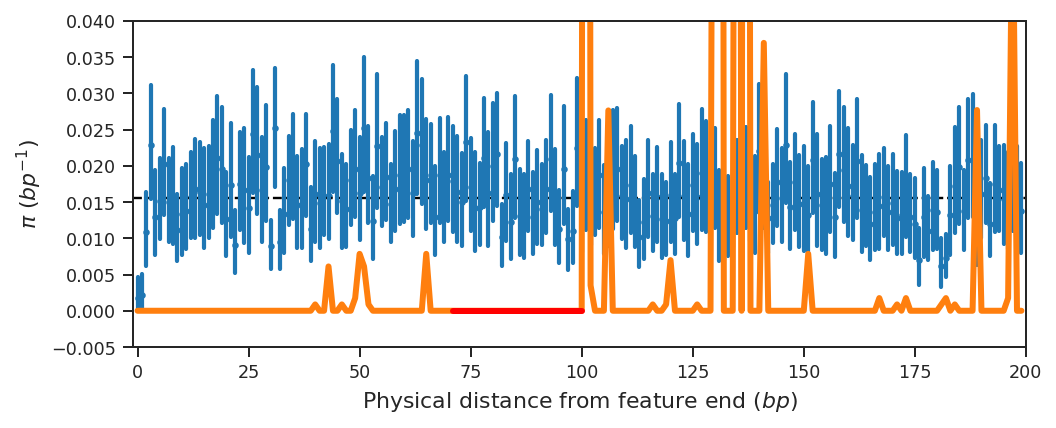

In [32]:
def plot_dsx_against_intron_diversity_end(dsx_data, dsx_acc, title = None):
    
    cls = CLS_INTRON_LAST
    x_max = 200
    y_min = -0.005
    y_max = 0.04
    min_flen = 200

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos_end < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos_end[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    # since there is only one section of inaccessible bases in dsx, we can vary the line colour thusly
    ax.plot(range(200), dsx_data, lw=3)
    ax.plot(np.array(range(200))[np.invert(dsx_acc)], dsx_data[np.invert(dsx_acc)], lw=3, c = 'red')   
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature end ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    #ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

# The blue bars are mean +- 95% conf calculated across 2R. The line shows the observed values for
# the dsx focal intron (organge = accessible, red = inaccessible, bearing in mind that inacessible
# SNPs were not counted, so mpd is always 0 here).
plot_dsx_against_intron_diversity_end(dsx_mpd, dsx_acc)

In [33]:
# Get the distribution of values from introns at least 200bp long, but take only the last 100bp of those introns
flt = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen > 200) & (seq_relpos_end < 100)
# If we want to look at only the "last" intron, use this instead
#flt = (seq_cls == CLS_INTRON_LAST) & (seq_flen > 200) & (seq_relpos_end < 100)
values = seq_mpd[flt]

# We use the intron_group_values to separate the mpd values by the intron to which they belong
seq_intron_group_values = seq_intron_group[flt]
seq_relpos_end_values = seq_relpos_end[flt]
values_grouped = pd.Series(values).groupby(seq_intron_group_values)

In [34]:
# Get the mean mpd values for every intron from which we have at least 20 accessible bases among those 
# last 100 bp. This only uses accessible bases as inaccessible bases were removed when seq_mpd was
# calculated.
intron_group_sizefilter = values_grouped.size() >= 20
intron_group_mpd = values_grouped.mean()[intron_group_sizefilter]
# Now calculate the mean mpd of the last 100 bp dsx intron, removing inaccessible positions. 
dsx_mean_mpd = np.mean(dsx_mpd[:100][dsx_acc[:100]])
# As expected, one of the grouped means is exactly equal to the dsx mean (because dsx is one 
# of the groups):
print(np.sum(intron_group_mpd == dsx_mean_mpd))
# So we remove that value from the group means
intron_group_mpd = intron_group_mpd[np.invert(intron_group_mpd == dsx_mean_mpd)]


1


In [35]:
# What proportion of the distribution is at least as small as the dsx intron?
np.sum(intron_group_mpd <= np.mean(dsx_mean_mpd)) / len(intron_group_mpd)

0.011695906432748537

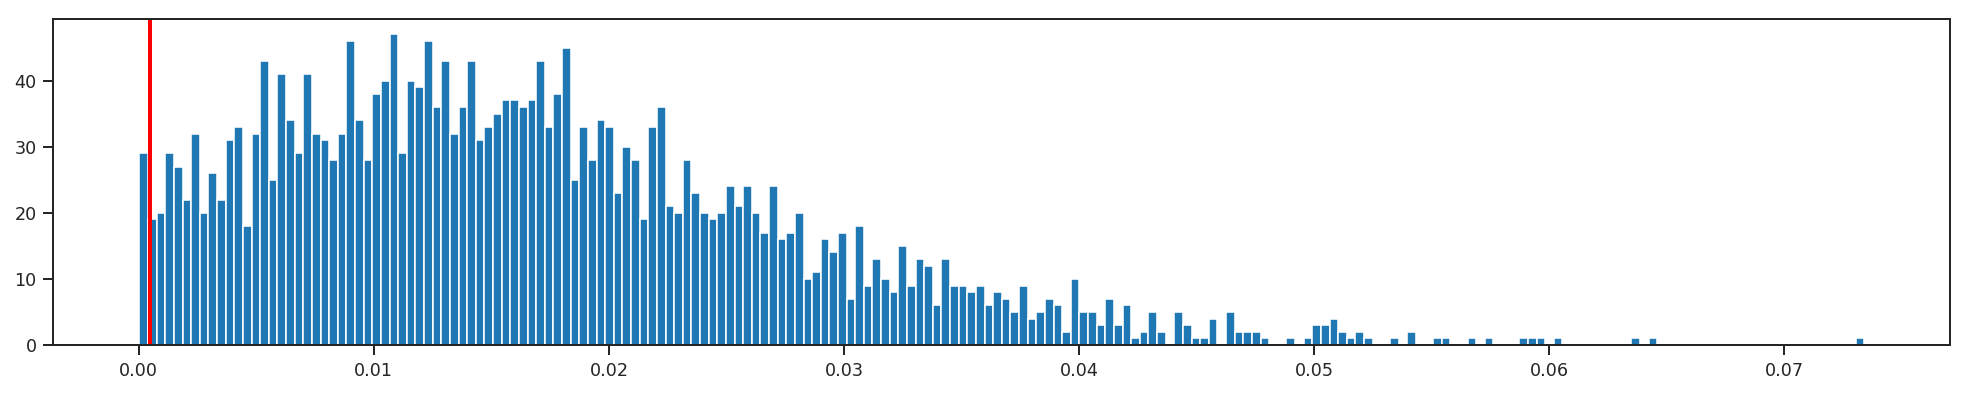

In [36]:
# About 1% of values are at least as small as what we observe in the dsx intron.
# Where does that value plot on a histgram?
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(intron_group_mpd, bins = 200)
ax.axvline(dsx_mean_mpd, color='red', lw = 2)
plt.show()

In [37]:
# So while dsx in nearly in the first percentile of the distribution, I wouldn't call it an outlier. 
# Doing a test of statistical significance doesn't really makes sense, I think. I feel that the 
# question "is this intron significantly different from the other introns" would only make sense
# if this intron was an outlier, which it doesn't really appear to be from the distribution above.
# Still, just for completeness, let's see what happens when we do a Mann-Whitney U test.
from scipy.stats import mannwhitneyu
mannwhitneyu([dsx_mean_mpd], intron_group_mpd)
# It's borderline significant

MannwhitneyuResult(statistic=32.0, pvalue=0.04548679258478106)

In [38]:
# I have also tried running this using only the "last" introns for comparisons, and the results
# are pretty much the same 

In [39]:
# OK, now we want to do this across the whole gene. How do we do this? We can't just plot diversity
# along the whole gene because what would we compare it with?


In [40]:
# Re-calculate some of the feature tables calculated inside the compute_features function, but this
# time make them globally visible.

tbl_features = (
    get_features(chrom)
    .convert('start', lambda v: v-1)
    .rename('end', 'stop')
    .unpackdict('attributes', ['Parent', 'ID'])
    .rename('Parent', 'parent')
    .addfield('length', lambda rec: rec.stop-rec.start, index=5)
    .cache()
)
tbl_genes = tbl_features.eq('type', 'gene')    

# obtain CDSs
##############

def child_first(prv, cur, nxt):
    return (
        (cur.strand == '+' and (prv is None or prv.parent != cur.parent))
        or (cur.strand == '-') and (nxt is None or cur.parent != nxt.parent)
    )

def child_last(prv, cur, nxt):
    return (
        (cur.strand == '-' and (prv is None or prv.parent != cur.parent))
        or (cur.strand == '+') and (nxt is None or cur.parent != nxt.parent)
    )

tbl_cdss = (
    tbl_features
    .eq('type', 'CDS')
    .select('parent', lambda v: v.endswith('RA'))
    .addfieldusingcontext('first', child_first)
    .addfieldusingcontext('last', child_last)
)    

# obtain introns
#################

def cds2intron(parent, cdss):
    cdss = list(cdss)
    seqid = cdss[0].seqid
    strand = cdss[0].strand
    type = 'intron'
    for i in range(1, len(cdss)):
        start = cdss[i-1].stop
        stop = cdss[i].start
        yield (seqid, type, start, stop, stop-start, strand, parent)

tbl_introns = (
    tbl_cdss
    .rowgroupmap(key='parent', mapper=cds2intron, header=['seqid', 'type', 'start', 'stop', 'length', 'strand', 'parent'])
    .addfieldusingcontext('first', child_first)
    .addfieldusingcontext('last', child_last)
)

In [41]:
pd.DataFrame(np.array(etl.search(tbl_introns, 'AGAP004050')))

,0,1,2,3,4,5,6,7,8
0,seqid,type,start,stop,length,strand,parent,first,last
1,2R,intron,48714648,48715160,512,-,AGAP004050-RA,False,True
2,2R,intron,48715295,48747692,32397,-,AGAP004050-RA,False,False
3,2R,intron,48747737,48784184,36447,-,AGAP004050-RA,True,False


In [42]:
pd.DataFrame(np.array(etl.search(tbl_features, 'AGAP004050').eq('type', 'CDS')))

,0,1,2,3,4,5,6,7,8,9,10
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID
1,2R,VectorBase,CDS,48711598,48712794,1196,.,-,2,AGAP004050-RB,AGAP004050-PB
2,2R,VectorBase,CDS,48714556,48714648,92,.,-,2,AGAP004050-RA,AGAP004050-PA
3,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RA,AGAP004050-PA
4,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RB,AGAP004050-PB
5,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RA,AGAP004050-PA
6,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RB,AGAP004050-PB
7,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RA,AGAP004050-PA
8,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RB,AGAP004050-PB


In [43]:
# Some all of the introns are long, but some of the exons are short (45 or 135 bp)

# The start and end of the dsx gene are at 48703663 and 48788460 (although panoptes says it goes 
# to 48792262)

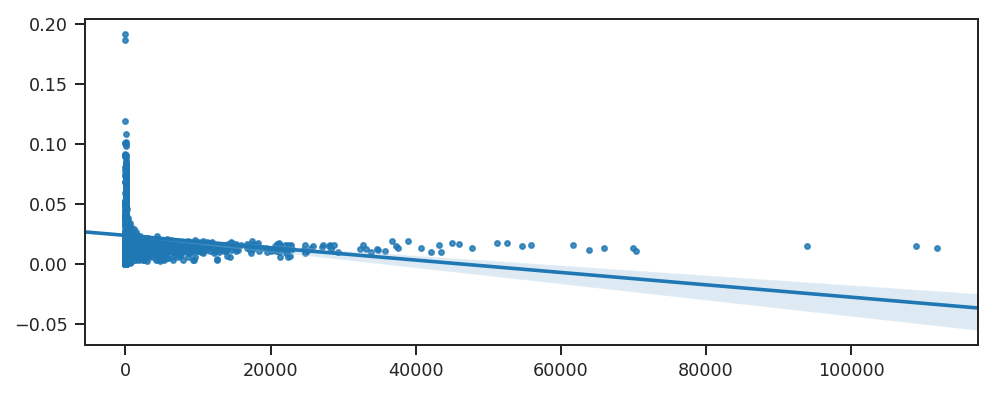

In [44]:
# OK, first off, how does mean mpd correlate with intron length?
# Get the positions of interest 
intron_positions = (seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)
# If we want to look at only the "last" intron, use this instead
#flt = seq_cls == CLS_INTRON_LAST
intron_values = seq_mpd[intron_positions]

# We separate the mpd values by the intron to which they belong
seq_intron_group_values_2 = seq_intron_group[intron_positions]
intron_values_grouped = pd.Series(intron_values).groupby(seq_intron_group_values_2)

intron_group_sizes = intron_values_grouped.size()
intron_group_mpd_2 = intron_values_grouped.mean()

fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(intron_group_sizes, intron_group_mpd_2, ax=ax, scatter_kws=dict(s=6))
plt.show()

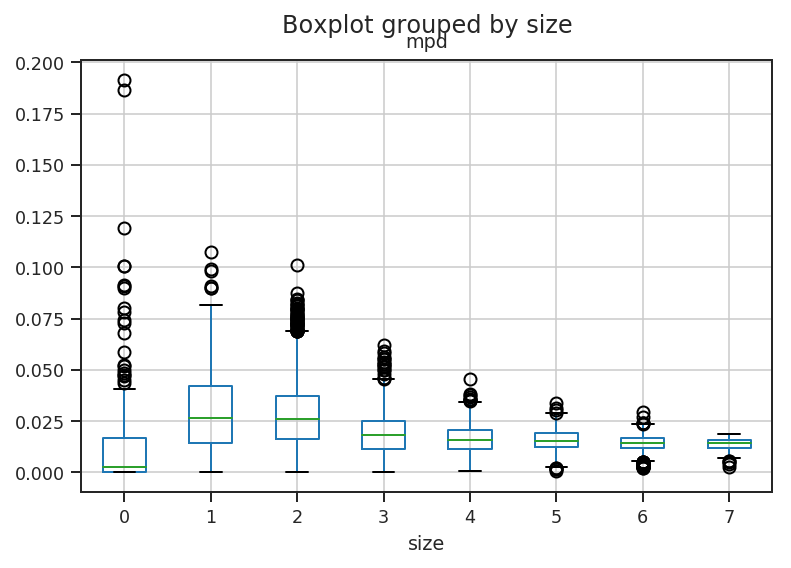

In [45]:
# Let's make some bins for a clearer plot
intron_size_bins = ((intron_group_sizes > 20).astype(int) +
    (intron_group_sizes > 50).astype(int) +
    (intron_group_sizes > 100).astype(int) +
    (intron_group_sizes > 200).astype(int) +
    (intron_group_sizes > 500).astype(int) +
    (intron_group_sizes > 1000).astype(int) +
    (intron_group_sizes > 10000).astype(int))
intron_mpd_by_size = intron_group_mpd_2.groupby(intron_size_bins)

pd.DataFrame({'size': intron_size_bins, 'mpd': intron_group_mpd_2}).boxplot(column = 'mpd', by = 'size')

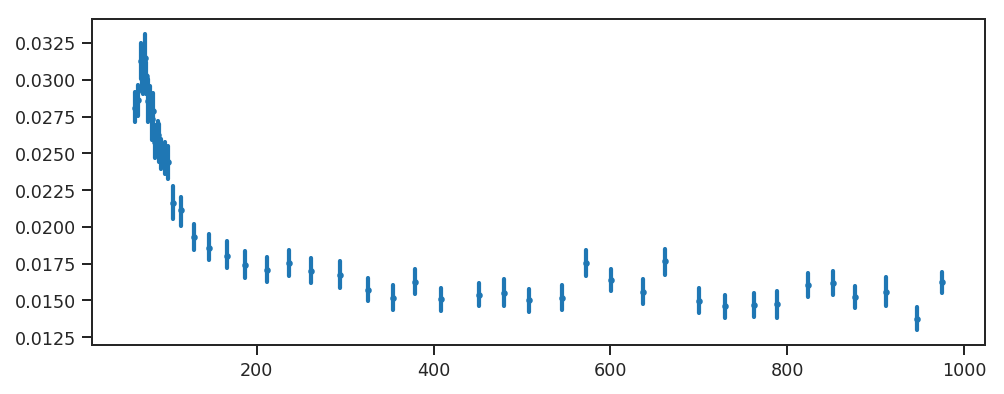

In [46]:
# Or we recreate Alistair's plot
intron_positions_1000 = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen < 1000)
intron_values_1000 = seq_mpd[intron_positions_1000]
intron_sizes_1000 = seq_flen[intron_positions_1000]
fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(intron_sizes_1000, intron_values_1000, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
plt.show()



In [47]:
# For introns, we are probably happy with taking a size cut-off of 300, since the smallest intron in dsx
# is 500bp. Let's look at the distribution of mean mpd for all introns of this size and see where the 
# three dsx introns fit in
# First, get the mean mpd in each of the three introns of dsx
dsx_intron_start_pos = etl.columns(etl.search(tbl_introns, 'AGAP004050'))['start']
dsx_intron_end_pos = etl.columns(etl.search(tbl_introns, 'AGAP004050'))['stop']

In [48]:
# Get the accessibility and mpd for each intron as a list
dsx_intron_ranges = [range(dsx_intron_start_pos[i], dsx_intron_end_pos[i]) for i in range(len(dsx_intron_start_pos))]
dsx_intron_acc = [accessibility[chrom]['is_accessible'][dsx_intron_ranges[i]] for i in range(len(dsx_intron_ranges))]
dsx_intron_mpd = [seq_mpd_nofilter[dsx_intron_ranges[i]] for i in range(len(dsx_intron_ranges))]
# Now get the mean of accessible mpds
dsx_intron_mean_mpd = [np.mean(dsx_intron_mpd[i][dsx_intron_acc[i]]) for i in range(len(dsx_intron_ranges))]
dsx_intron_mean_mpd

[0.013858225287477318, 0.009612671289504686, 0.009655191480884001]

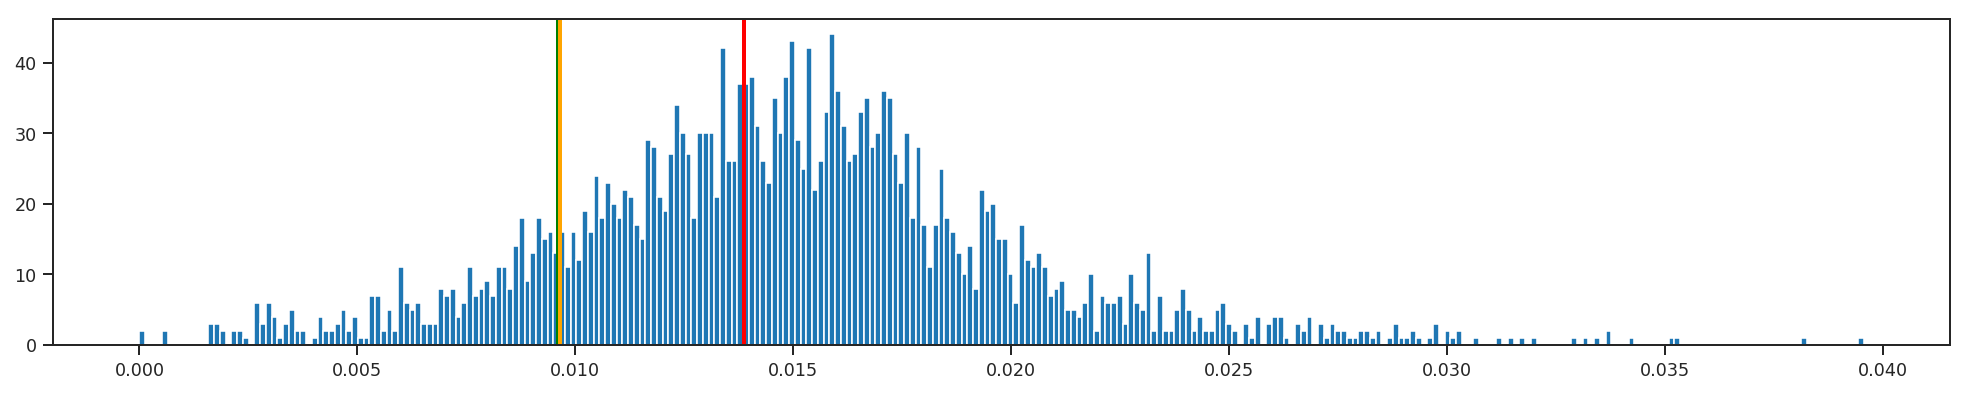

In [49]:
# Now plot the histogram of all mean mpds and show where the 3 dsx introns lie
intron_positions_300min = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen > 300)
intron_values_300min = seq_mpd[intron_positions_300min]
seq_intron_group_values_300min = seq_intron_group[intron_positions_300min]
intron_values_grouped_300min = pd.Series(intron_values_300min).groupby(seq_intron_group_values_300min)
intron_group_sizefilter_300min = intron_values_grouped_300min.size() >= 20
intron_group_mpd_300min = intron_values_grouped_300min.mean()[intron_group_sizefilter_300min]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(intron_group_mpd_300min, bins = 300)
ax.axvline(dsx_intron_mean_mpd[0], color='red', lw = 2)
ax.axvline(dsx_intron_mean_mpd[1], color='green', lw = 2)
ax.axvline(dsx_intron_mean_mpd[2], color='orange', lw = 2)
plt.show()


In [50]:
# Let's confirm that each of those introns is indeed present in the distribution
print(np.sum(np.round(intron_group_mpd_300min, 10) == np.round(dsx_intron_mean_mpd[0], 10)))
print(np.sum(np.round(intron_group_mpd_300min, 10) == np.round(dsx_intron_mean_mpd[1], 10)))
print(np.sum(np.round(intron_group_mpd_300min, 10) == np.round(dsx_intron_mean_mpd[2], 10)))

1
0
1


In [51]:
# The calculated value for the second intron is not found in our distribution of all introns. I happen
# to know that the group number for this intron in the distribution is 8247. We can see that the values
# are not the same. 
print(dsx_intron_mean_mpd[1])
print(np.mean(intron_values_grouped_300min.get_group(8247)))
# The reason for this is that this intron contains an entire gene on the other strand. Given the way that
# introns and CDS regions are determined, the CDS of the other gene still gets coded as intronic region 
# 8247 (which we may want to deal with at some point). However, the intronic regions of the other strand
# overwrite the intronic region of dsx, and thus are given a new group number. This is what gets used to 
# calculate the value in the distribution. On the other hand, our targeted calculation of the dsx intron
# just uses the positions between the start and end points of the intron, so those regions that are also 
# introns in the other gene also get counted. The difference in value is not huge, so let's leave it for 
# now and maybe we'll come back to it later. 

0.009612671289504686
0.009578572730486882


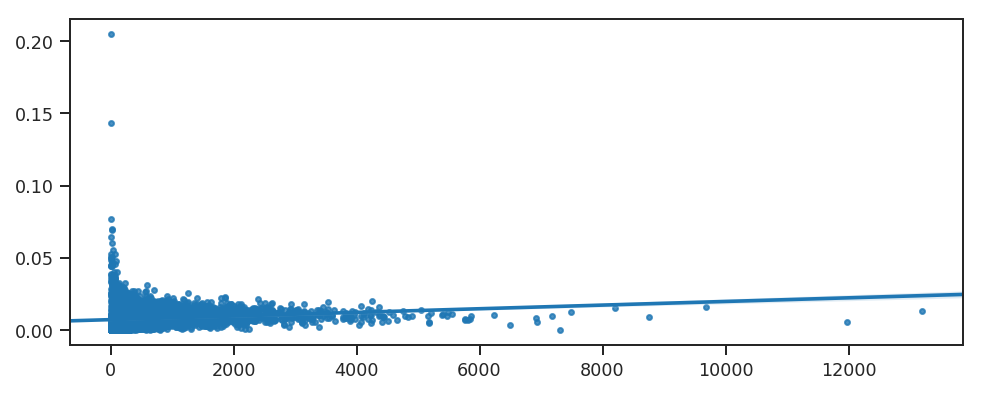

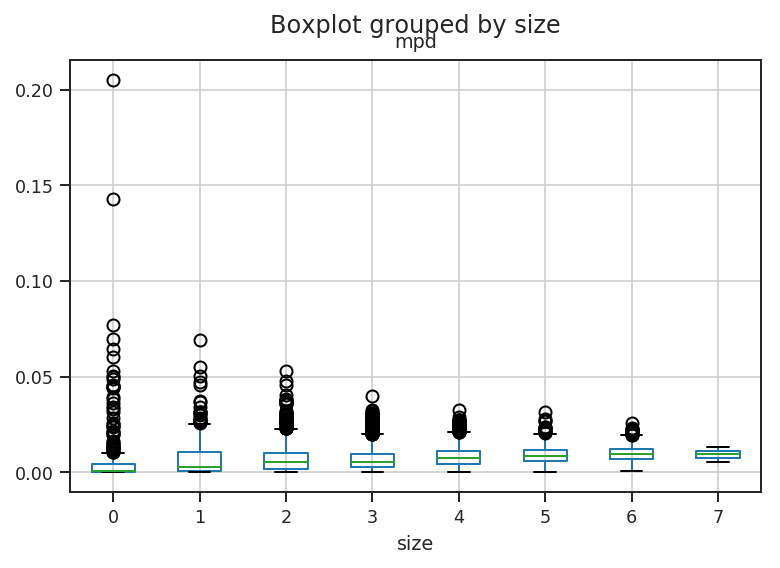

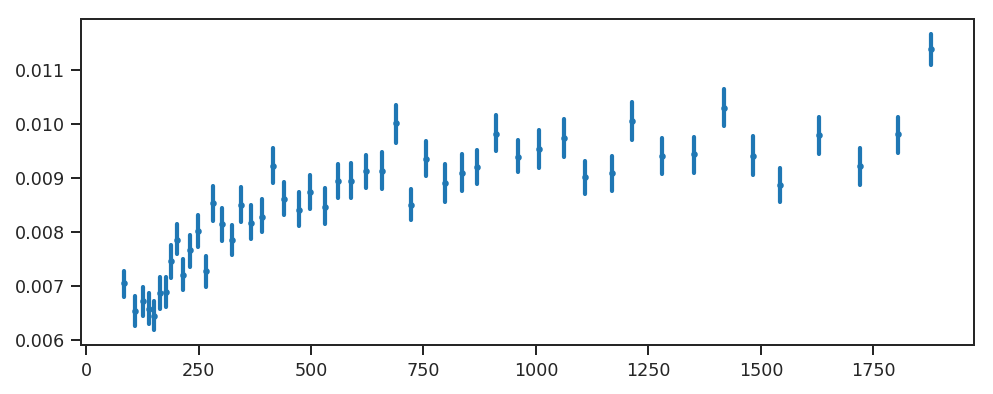

In [52]:
# Now let's do the same for exons
exon_positions = (seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)
exon_values = seq_mpd[exon_positions]

# We separate the mpd values by the intron to which they belong
seq_exon_group_values = seq_exon_group[exon_positions]
exon_values_grouped = pd.Series(exon_values).groupby(seq_exon_group_values)

exon_group_sizes = exon_values_grouped.size()
exon_group_mpd = exon_values_grouped.mean()

fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_group_sizes, exon_group_mpd, ax=ax, scatter_kws=dict(s=6))
plt.show()

exon_size_bins = ((exon_group_sizes > 20).astype(int) +
    (exon_group_sizes > 50).astype(int) +
    (exon_group_sizes > 100).astype(int) +
    (exon_group_sizes > 200).astype(int) +
    (exon_group_sizes > 500).astype(int) +
    (exon_group_sizes > 1000).astype(int) +
    (exon_group_sizes > 10000).astype(int))
exon_mpd_by_size = exon_group_mpd.groupby(exon_size_bins)

pd.DataFrame({'size': exon_size_bins, 'mpd': exon_group_mpd}).boxplot(column = 'mpd', by = 'size')

exon_positions_2000 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 2000)
exon_values_2000 = seq_mpd[exon_positions_2000]
exon_sizes_2000 = seq_flen[exon_positions_2000]
fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_sizes_2000, exon_values_2000, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
plt.show()

In [53]:
# What is the size distribution of dsx exons? The exon detection method currently only keeps the 
# -RA transcripts
pd.DataFrame(np.array(etl.search(tbl_cdss, 'AGAP004050')))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID,first,last
1,2R,VectorBase,CDS,48714556,48714648,92,.,-,2,AGAP004050-RA,AGAP004050-PA,False,True
2,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RA,AGAP004050-PA,True,False
3,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RA,AGAP004050-PA,False,True
4,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RA,AGAP004050-PA,True,False


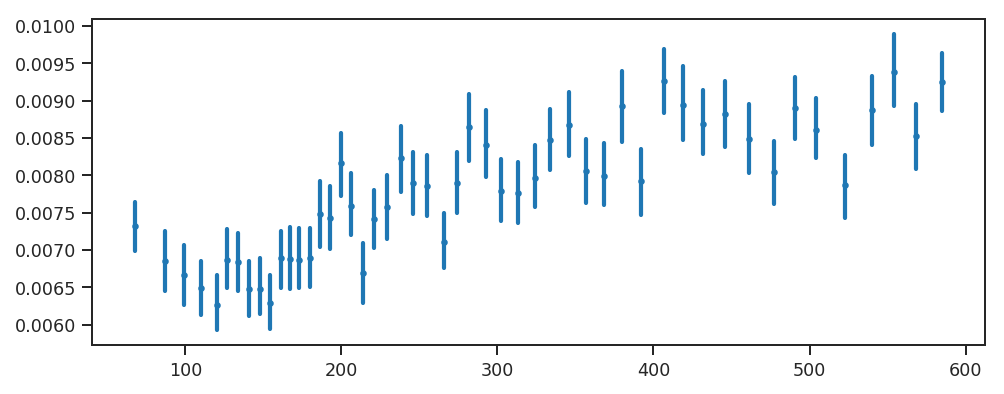

In [54]:
# These are quite small exons, which is problematic for comparing them to the expectation, since
# the expectation in this size range is very dependent on exon size. Let's look again at the 
# relationship with size, but zooming in to the size range of interest
exon_positions_600 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 600)
exon_values_600 = seq_mpd[exon_positions_600]
exon_sizes_600 = seq_flen[exon_positions_600]
fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_sizes_600, exon_values_600, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
plt.show()

In [153]:
# Get the mean mpd in each of the four exons of dsx
dsx_exon_start_pos = etl.columns(etl.search(tbl_cdss, 'AGAP004050'))['start']
dsx_exon_end_pos = etl.columns(etl.search(tbl_cdss, 'AGAP004050'))['stop']
# Get the accessibility and mpd for each exon as a list
dsx_exon_ranges = [range(dsx_exon_start_pos[i], dsx_exon_end_pos[i]) for i in range(len(dsx_exon_start_pos))]
dsx_exon_acc = [accessibility[chrom]['is_accessible'][dsx_exon_ranges[i]] for i in range(len(dsx_exon_ranges))]
dsx_exon_mpd = [seq_mpd_nofilter[dsx_exon_ranges[i]] for i in range(len(dsx_exon_ranges))]
# Now get the mean of accessible mpds
dsx_exon_mean_mpd = [np.mean(dsx_exon_mpd[i][dsx_exon_acc[i]]) for i in range(len(dsx_exon_ranges))]

# Now get the same means, but split by coding position
dsx_exon_relpos = [seq_relpos_nofilter[dsx_exon_ranges[i]] for i in range(len(dsx_exon_ranges))]
#
dsx_exon_mpd_1 = [dsx_exon_mpd[i][dsx_exon_relpos[i]%3 == 0] for i in range(len(dsx_exon_ranges))]
dsx_exon_mpd_2 = [dsx_exon_mpd[i][dsx_exon_relpos[i]%3 == 1] for i in range(len(dsx_exon_ranges))]
dsx_exon_mpd_3 = [dsx_exon_mpd[i][dsx_exon_relpos[i]%3 == 2] for i in range(len(dsx_exon_ranges))]
dsx_exon_acc_1 = [dsx_exon_acc[i][dsx_exon_relpos[i]%3 == 0] for i in range(len(dsx_exon_ranges))]
dsx_exon_acc_2 = [dsx_exon_acc[i][dsx_exon_relpos[i]%3 == 1] for i in range(len(dsx_exon_ranges))]
dsx_exon_acc_3 = [dsx_exon_acc[i][dsx_exon_relpos[i]%3 == 2] for i in range(len(dsx_exon_ranges))]
#
dsx_exon_mean_mpd_1 = [np.mean(dsx_exon_mpd_1[i][dsx_exon_acc_1[i]]) for i in range(len(dsx_exon_ranges))]
dsx_exon_mean_mpd_2 = [np.mean(dsx_exon_mpd_2[i][dsx_exon_acc_2[i]]) for i in range(len(dsx_exon_ranges))]
dsx_exon_mean_mpd_3 = [np.mean(dsx_exon_mpd_3[i][dsx_exon_acc_3[i]]) for i in range(len(dsx_exon_ranges))]



[91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68
 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44
 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20
 19 18 17 16 15 14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00087566,
       0.        , 0.        , 0.        , 0.        , 0.     

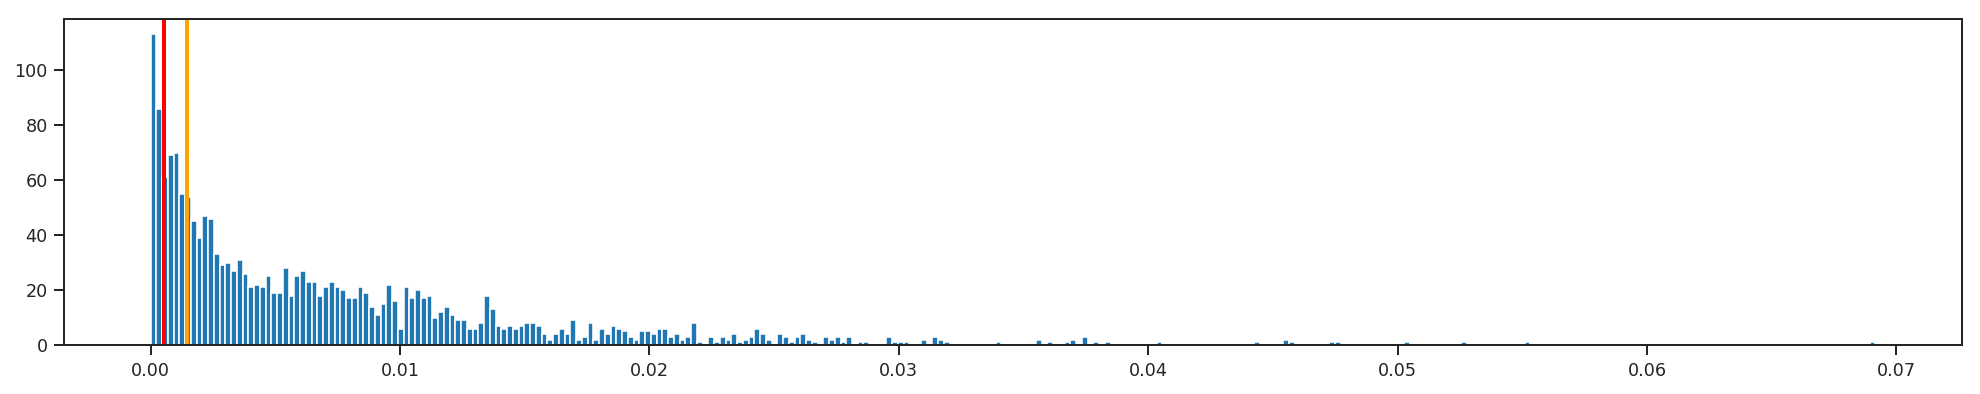

In [56]:
# Let's use exons smaller than 100 for the two smallest exons
exon_positions_100max = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 100)
exon_values_100max = seq_mpd[exon_positions_100max]
seq_exon_group_values_100max = seq_exon_group[exon_positions_100max]
exon_values_grouped_100max = pd.Series(exon_values_100max).groupby(seq_exon_group_values_100max)
exon_group_sizefilter_100max = exon_values_grouped_100max.size() >= 20
exon_group_mpd_100max = exon_values_grouped_100max.mean()[exon_group_sizefilter_100max]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max, bins = 300)
ax.axvline(dsx_exon_mean_mpd[0], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd[2], color='orange', lw = 2)
plt.show()



In [57]:
# What proportion of the distribution is at least as small as each of those exons?
print(np.sum(exon_group_mpd_100max <= np.mean(dsx_exon_mean_mpd[0])) / len(exon_group_mpd_100max))
print(np.sum(exon_group_mpd_100max <= np.mean(dsx_exon_mean_mpd[2])) / len(exon_group_mpd_100max))
# It's 12% and 25%

0.11955366631243358
0.24601487778958556


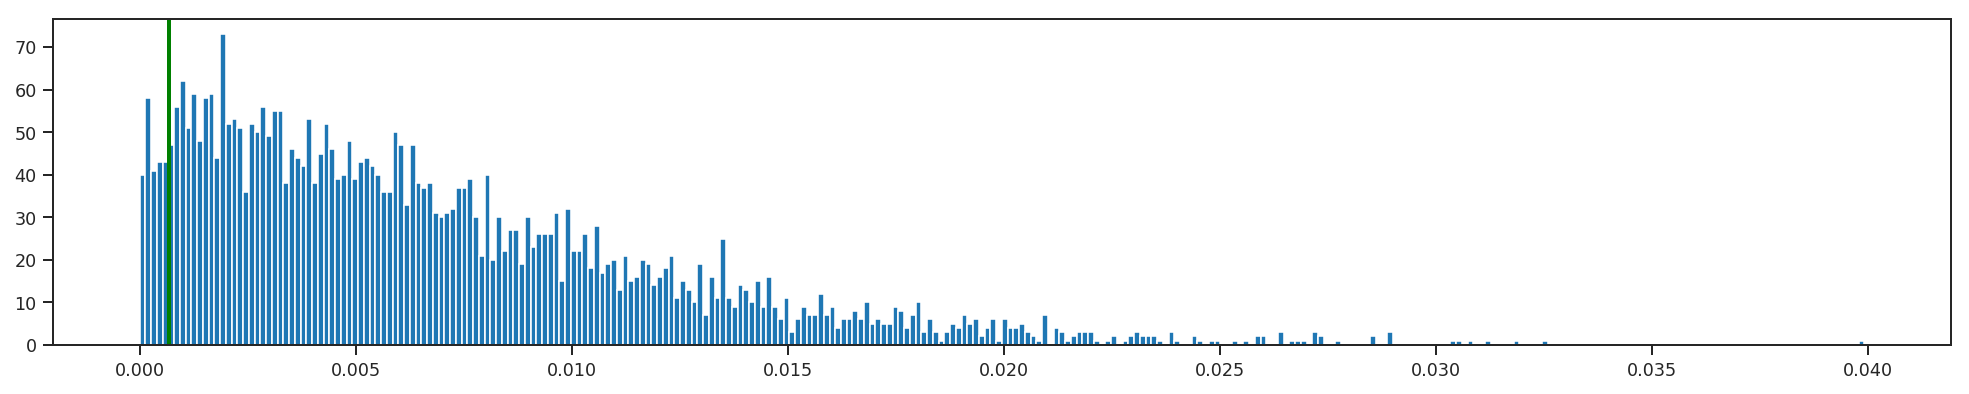

In [58]:
# For the 135bp-long exon, we use the 100-200 size range
exon_positions_100_200 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen > 100) & (seq_flen < 200)
exon_values_100_200 = seq_mpd[exon_positions_100_200]
seq_exon_group_values_100_200 = seq_exon_group[exon_positions_100_200]
exon_values_grouped_100_200 = pd.Series(exon_values_100_200).groupby(seq_exon_group_values_100_200)
exon_group_sizefilter_100_200 = exon_values_grouped_100_200.size() >= 20
exon_group_mpd_100_200 = exon_values_grouped_100_200.mean()[exon_group_sizefilter_100_200]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200, bins = 300)
ax.axvline(dsx_exon_mean_mpd[1], color='green', lw = 2)
plt.show()


In [59]:
# What proportion of the distribution is at least as small as the red vertical bar?
np.sum(exon_group_mpd_100_200 <= np.mean(dsx_exon_mean_mpd[1])) / len(exon_group_mpd_100_200)
# It's 6%

0.05838135805562516

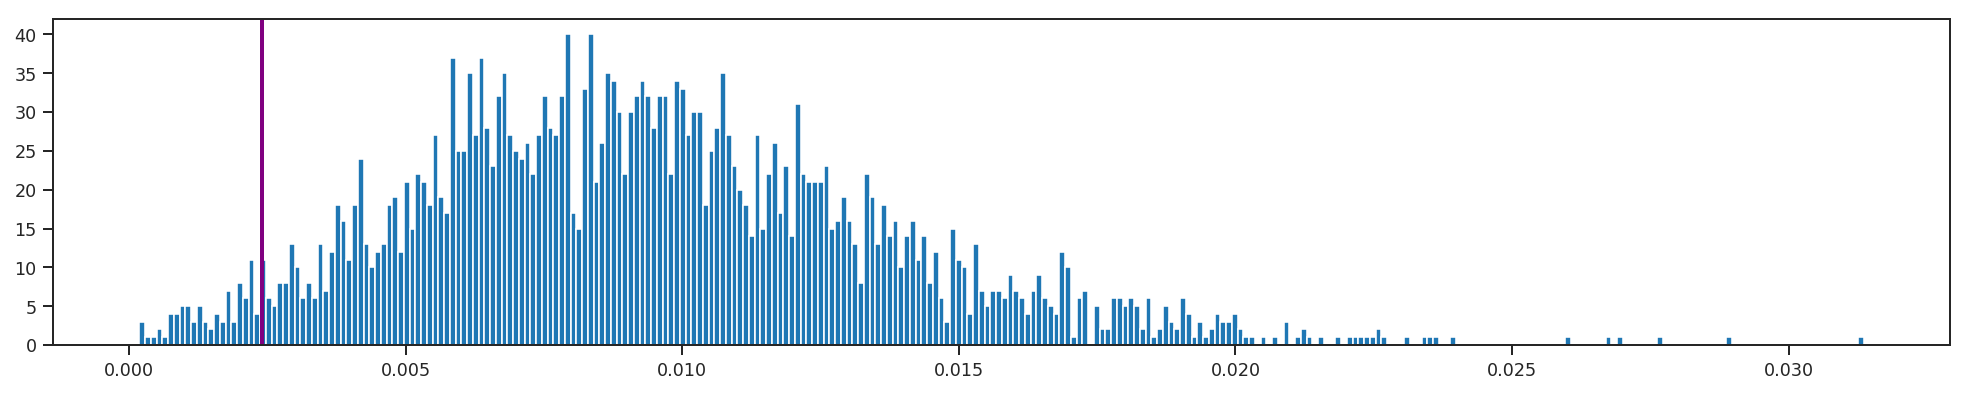

In [294]:
# For the longest exon, we use the 500+ distribution
exon_positions_500plus = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen > 500)
exon_values_500plus = seq_mpd[exon_positions_500plus]
seq_exon_group_values_500plus = seq_exon_group[exon_positions_500plus]
exon_values_grouped_500plus = pd.Series(exon_values_500plus).groupby(seq_exon_group_values_500plus)
exon_group_sizefilter_500plus = exon_values_grouped_500plus.size() >= 20
exon_group_mpd_500plus = exon_values_grouped_500plus.mean()[exon_group_sizefilter_500plus]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus, bins = 300)
ax.axvline(dsx_exon_mean_mpd[3], color='purple', lw = 2)
plt.show()


In [296]:
# What proportion of the distribution is at least as small as the exon?
np.sum(exon_group_mpd_500plus <= np.mean(dsx_exon_mean_mpd[3])) / len(exon_group_mpd_500plus)
# It's 3%

0.03

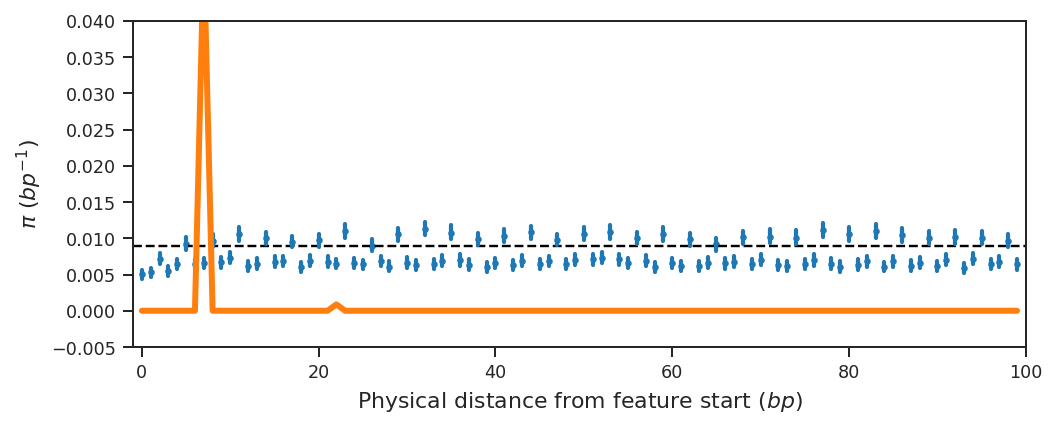

In [159]:
# Now let's split the exons by coding position
# Use relative position and isolate the ones that are multiples of 3 + 0, 1 or 2.

dsx_target_exon = range(endpos-111, endpos-11)
dsx_target_exon_acc = accessibility[chrom]['is_accessible'][dsx_target_exon]
dsx_target_exon_mpd = seq_mpd_nofilter[dsx_target_exon]

def plot_exon_diversity(dsx_data, dsx_acc, title = None):
    
    cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    x_max = 100
    y_min = -0.005
    y_max = 0.04
    min_flen = 0

    # compute overall mean
    m = np.mean(seq_mpd[np.isin(seq_cls, cls)])
    
    # obtain variables
    flt = np.isin(seq_cls, cls) & (seq_relpos < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(100), dsx_data[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(100))[np.invert(dsx_acc)[::-1]], dsx_data[np.invert(dsx_acc)][::-1], lw=3, c = 'red')   
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    #ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

# The blue bars are mean +- 95% conf calculated across 2R. The line shows the observed values for
# the dsx focal intron (organge = accessible, red = inaccessible, bearing in mind that inacessible
# SNPs were not counted, so mpd is always 0 here).
plot_exon_diversity(dsx_target_exon_mpd, dsx_target_exon_acc)


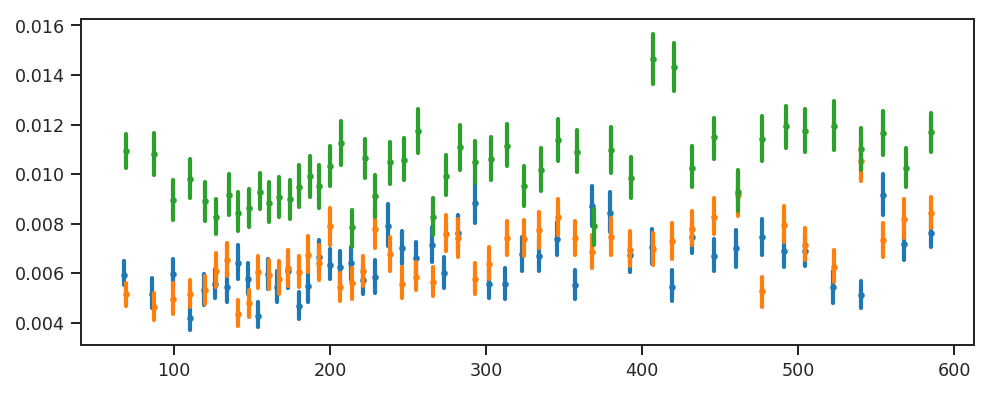

In [130]:
# Let's look at the distribution of exon diversity, separating by coding position
# First coding position:
exon_positions_600_1 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 600) & (seq_relpos%3 == 0)
exon_values_600_1 = seq_mpd[exon_positions_600_1]
exon_sizes_600_1 = seq_flen[exon_positions_600_1]
#fig, ax = plt.subplots(figsize=(8, 3))
#sns.regplot(exon_sizes_600_1, exon_values_600_1, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
#plt.show()

# Second coding position
exon_positions_600_2 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 600) & (seq_relpos%3 == 1)
exon_values_600_2 = seq_mpd[exon_positions_600_2]
exon_sizes_600_2 = seq_flen[exon_positions_600_2]
#fig, ax = plt.subplots(figsize=(8, 3))
#sns.regplot(exon_sizes_600_2, exon_values_600_2, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
#plt.show()

# Third coding position
exon_positions_600_3 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 600) & (seq_relpos%3 == 2)
exon_values_600_3 = seq_mpd[exon_positions_600_3]
exon_sizes_600_3 = seq_flen[exon_positions_600_3]
#fig, ax = plt.subplots(figsize=(8, 3))
#sns.regplot(exon_sizes_600_3, exon_values_600_3, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
#plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_sizes_600_1, exon_values_600_1, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
sns.regplot(exon_sizes_600_2, exon_values_600_2, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
sns.regplot(exon_sizes_600_3, exon_values_600_3, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
plt.show()

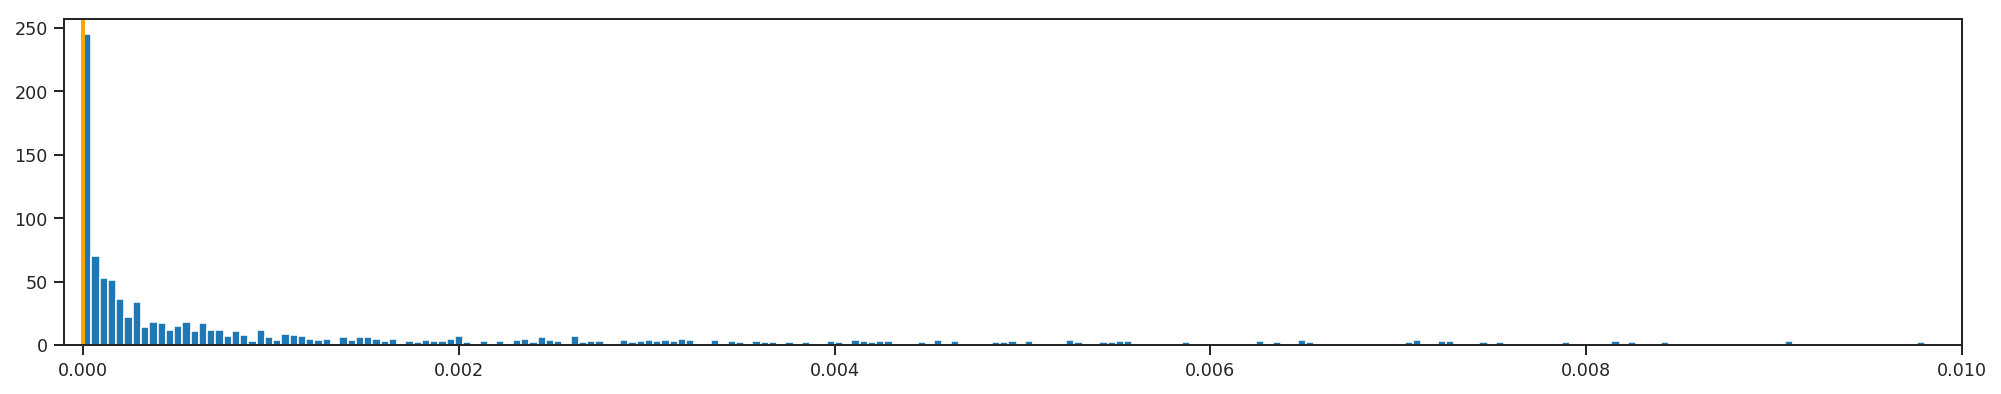

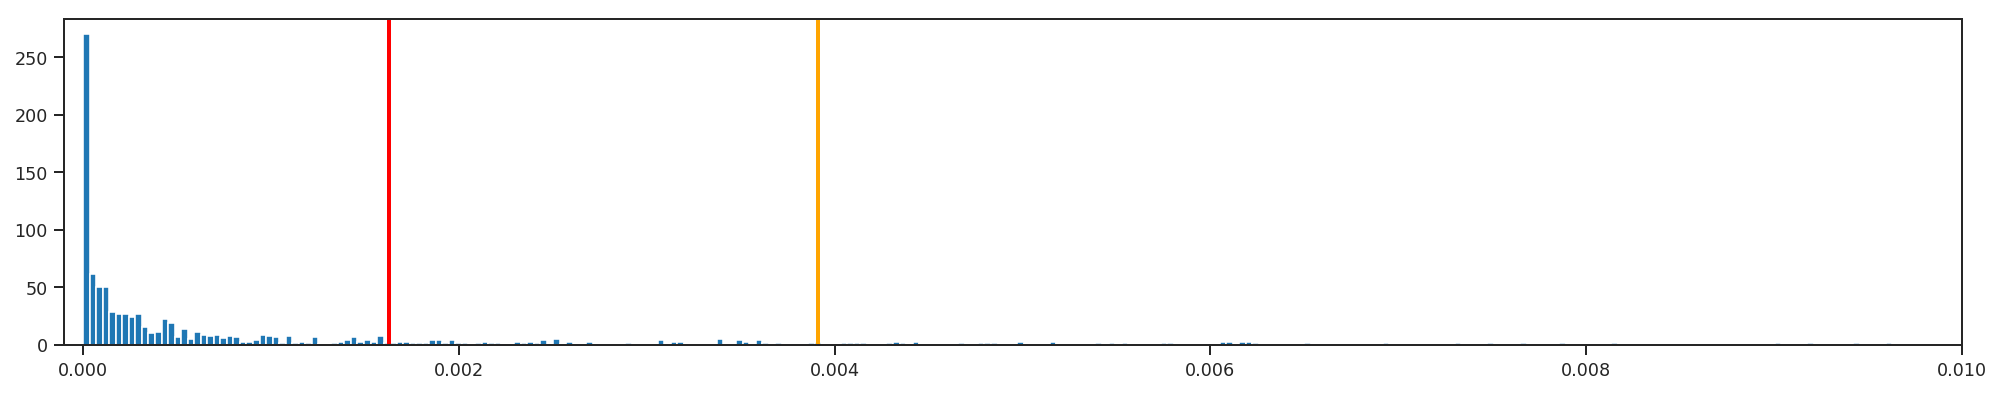

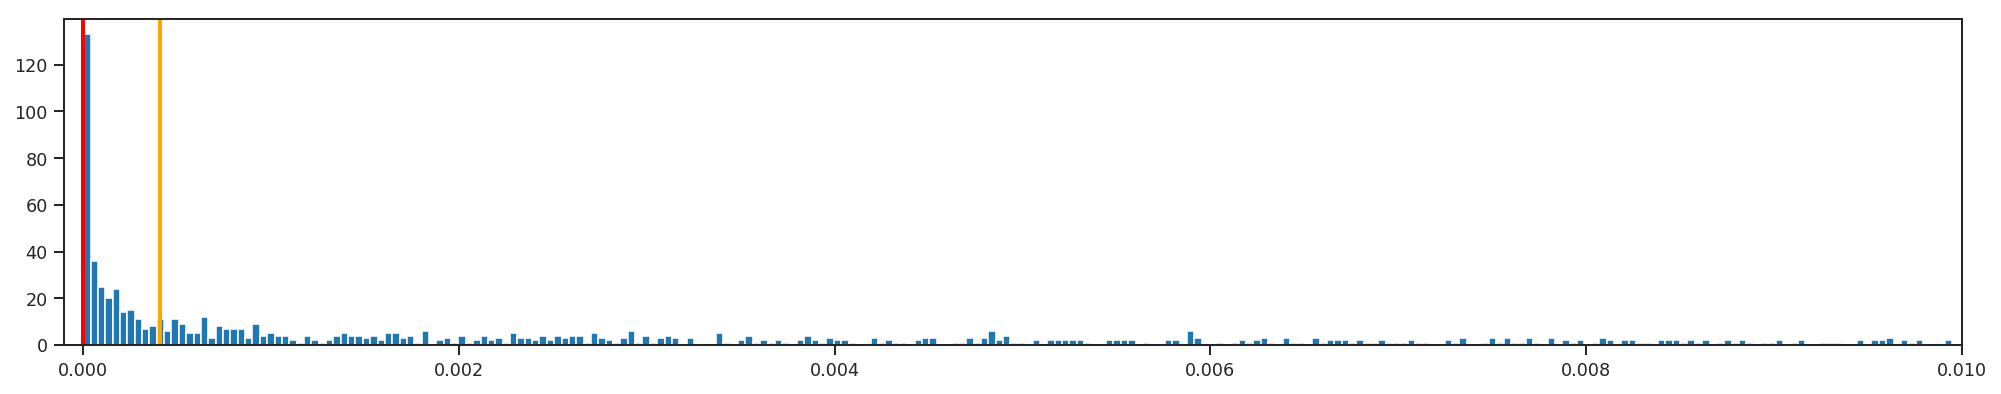

In [298]:
# How do the exons compare to the chromosome-wide distribution when splitting by coding position?
def get_mpd_by_coding_position(coding_position, minlen, maxlen):
    if maxlen == None:
        maxlen = np.inf
    exon_positions = np.isin(seq_cls, [CLS_EXON_LAST, CLS_EXON_MID, CLS_EXON_FIRST]) & (seq_flen >= minlen)  & (seq_flen <= maxlen) & (seq_relpos%3 == (coding_position -1))
    exon_values = seq_mpd[exon_positions]
    seq_exon_group_values = seq_exon_group[exon_positions]
    exon_values_grouped = pd.Series(exon_values).groupby(seq_exon_group_values)
    exon_group_sizefilter = exon_values_grouped.size() >= 20
    exon_group_mpd = exon_values_grouped.mean()[exon_group_sizefilter]
    return exon_group_mpd

# First coding position
exon_group_mpd_100max_1 = get_mpd_by_coding_position(1, 0, 100)

# Second coding position
exon_group_mpd_100max_2 = get_mpd_by_coding_position(2, 0, 100)

# Third coding position
exon_group_mpd_100max_3 = get_mpd_by_coding_position(3, 0, 100)

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max_1, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_1[0], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd_1[2], color='orange', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()
#
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max_2, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_2[0], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd_2[2], color='orange', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()
#
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max_3, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_3[0], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd_3[2], color='orange', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()

In [224]:
# What proportion of the distributions is at least as small as each of those exons?
print('First coding position:')
print(np.sum(exon_group_mpd_100max_1 <= np.mean(dsx_exon_mean_mpd_1[0])) / len(exon_group_mpd_100max_1))
print(np.sum(exon_group_mpd_100max_1 <= np.mean(dsx_exon_mean_mpd_1[2])) / len(exon_group_mpd_100max_1))
# It's 13% for both (becuase both have no variation, which is the case for 12% of exons)

print('Second coding position:')
print(np.sum(exon_group_mpd_100max_2 <= np.mean(dsx_exon_mean_mpd_2[0])) / len(exon_group_mpd_100max_2))
print(np.sum(exon_group_mpd_100max_2 <= np.mean(dsx_exon_mean_mpd_2[2])) / len(exon_group_mpd_100max_2))

print('Third coding position:')
print(np.sum(exon_group_mpd_100max_3 <= np.mean(dsx_exon_mean_mpd_3[0])) / len(exon_group_mpd_100max_3))
print(np.sum(exon_group_mpd_100max_3 <= np.mean(dsx_exon_mean_mpd_3[2])) / len(exon_group_mpd_100max_3))

# None of these look particularly impressive

First coding position:
0.12680334092634776
0.12680334092634776
Second coding position:
0.6346153846153846
0.7223076923076923
Third coding position:
0.08034321372854915
0.23400936037441497


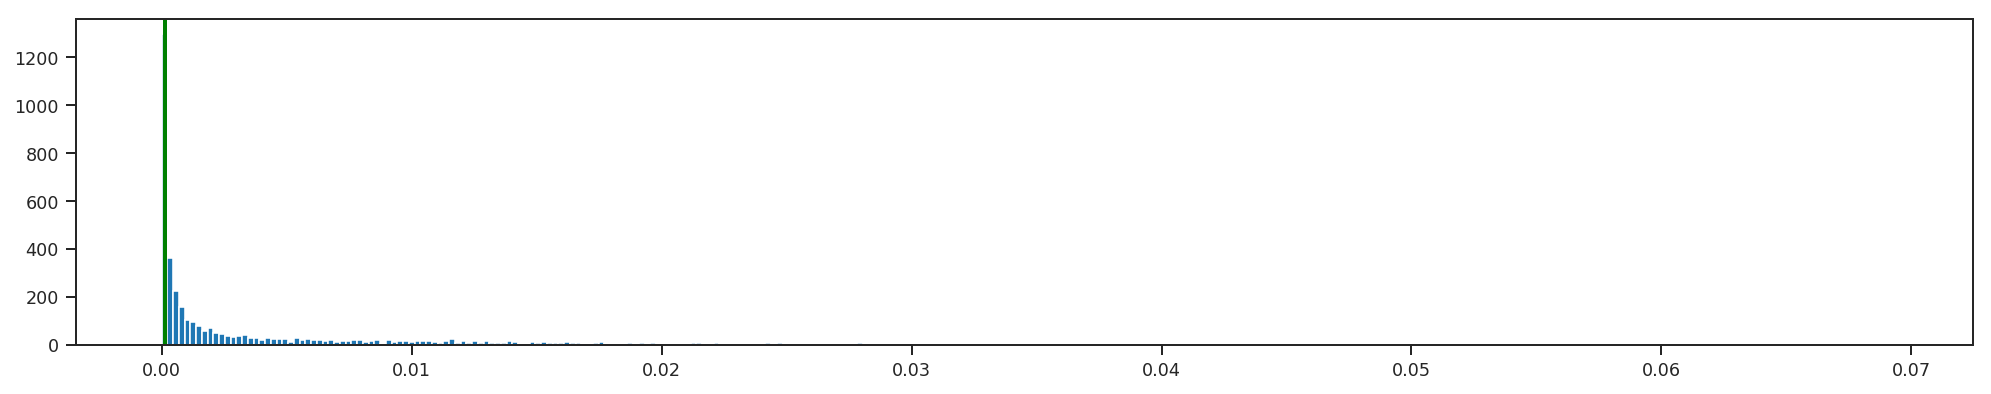

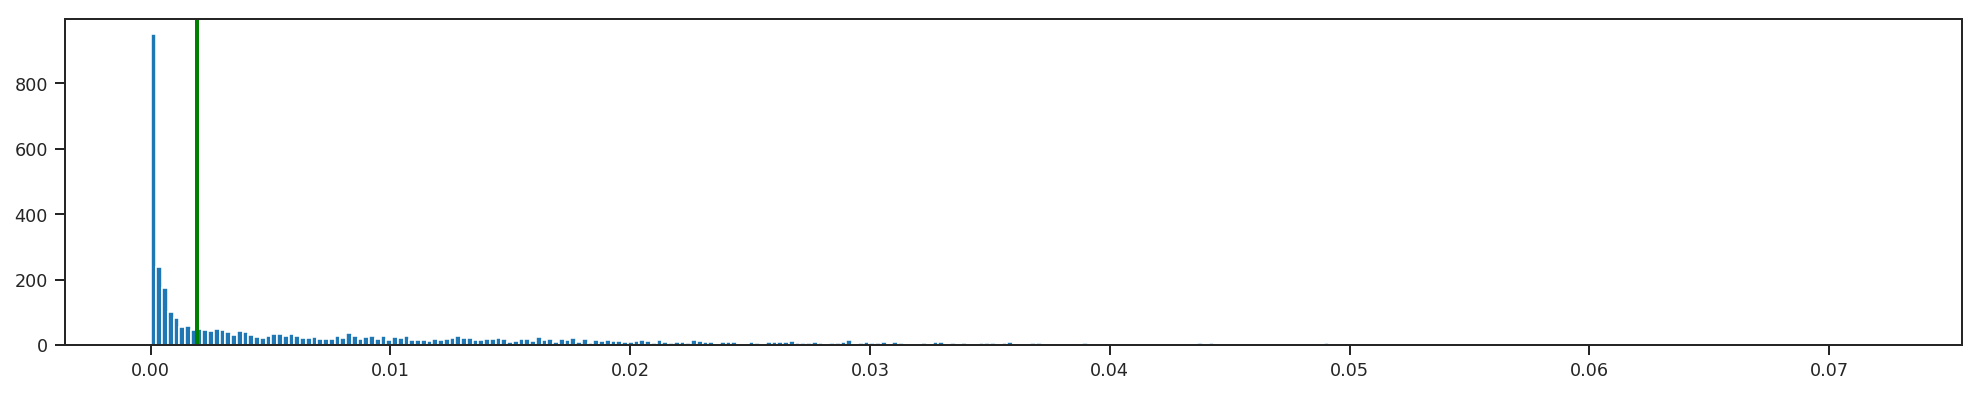

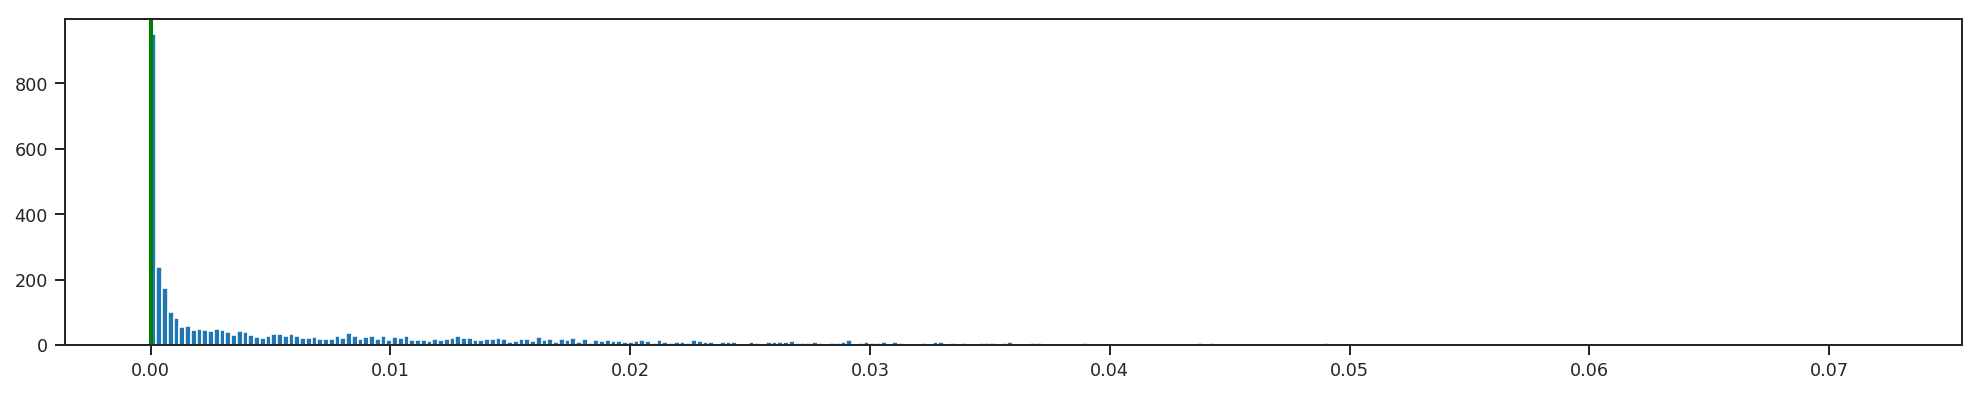

In [225]:
# For the 135bp-long exon, we use the 100-200 size range
exon_group_mpd_100_200_1 = get_mpd_by_coding_position(1, 100, 200)
exon_group_mpd_100_200_2 = get_mpd_by_coding_position(2, 100, 200)
exon_group_mpd_100_200_3 = get_mpd_by_coding_position(3, 100, 200)

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200_1, bins = 300)
ax.axvline(dsx_exon_mean_mpd_1[1], color='green', lw = 2)
plt.show()

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200_3, bins = 300)
ax.axvline(dsx_exon_mean_mpd_2[1], color='green', lw = 2)
plt.show()

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200_3, bins = 300)
ax.axvline(dsx_exon_mean_mpd_3[1], color='green', lw = 2)
plt.show()


In [229]:
# What proportion of the distributions is at least as small as that exon?
print('First coding position:')
print(np.sum(exon_group_mpd_100_200_1 <= np.mean(dsx_exon_mean_mpd_1[1])) / len(exon_group_mpd_100_200_1))

print('Second coding position:')
print(np.sum(exon_group_mpd_100_200_2 <= np.mean(dsx_exon_mean_mpd_2[1])) / len(exon_group_mpd_100_200_2))

print('Third coding position:')
print(np.sum(exon_group_mpd_100_200_3 <= np.mean(dsx_exon_mean_mpd_3[1])) / len(exon_group_mpd_100_200_3))

# Third coding position nearly significant here

First coding position:
0.2413707474546809
Second coding position:
0.6023348236462991
Third coding position:
0.05515527950310559


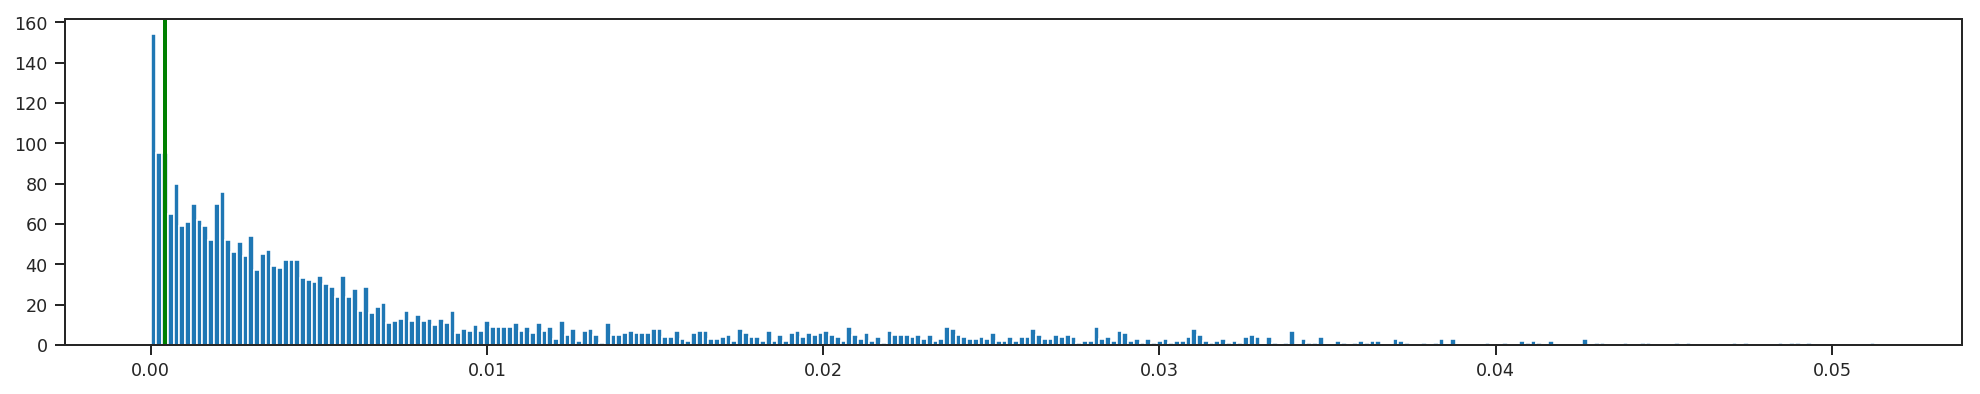

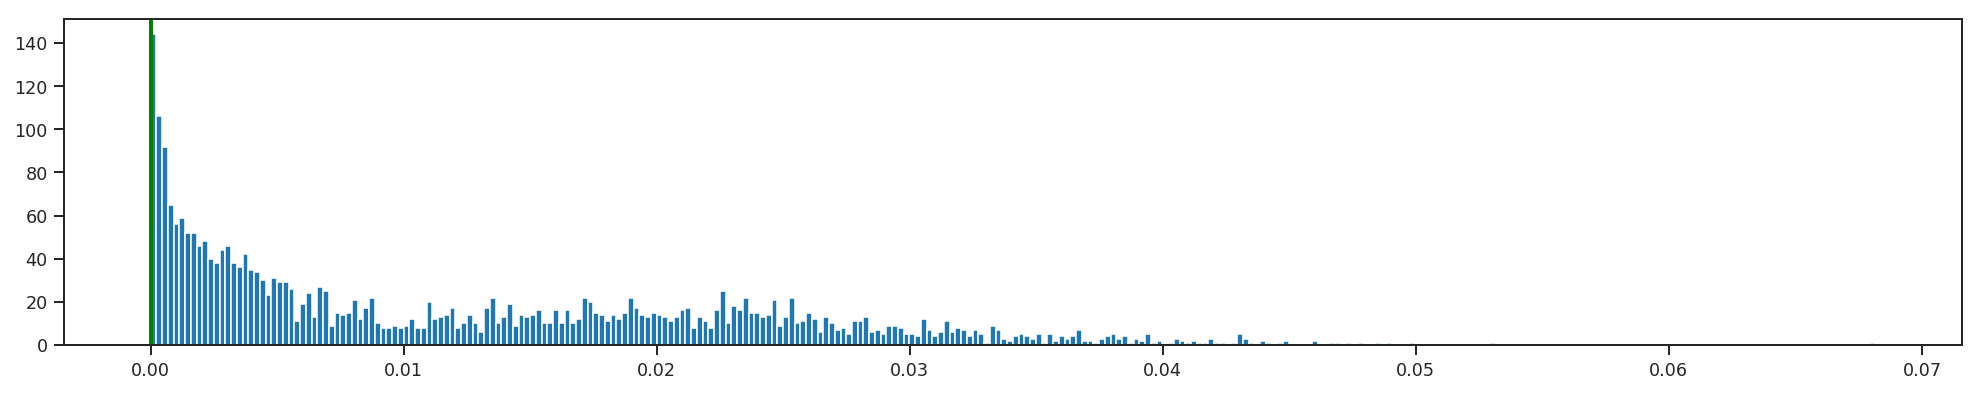

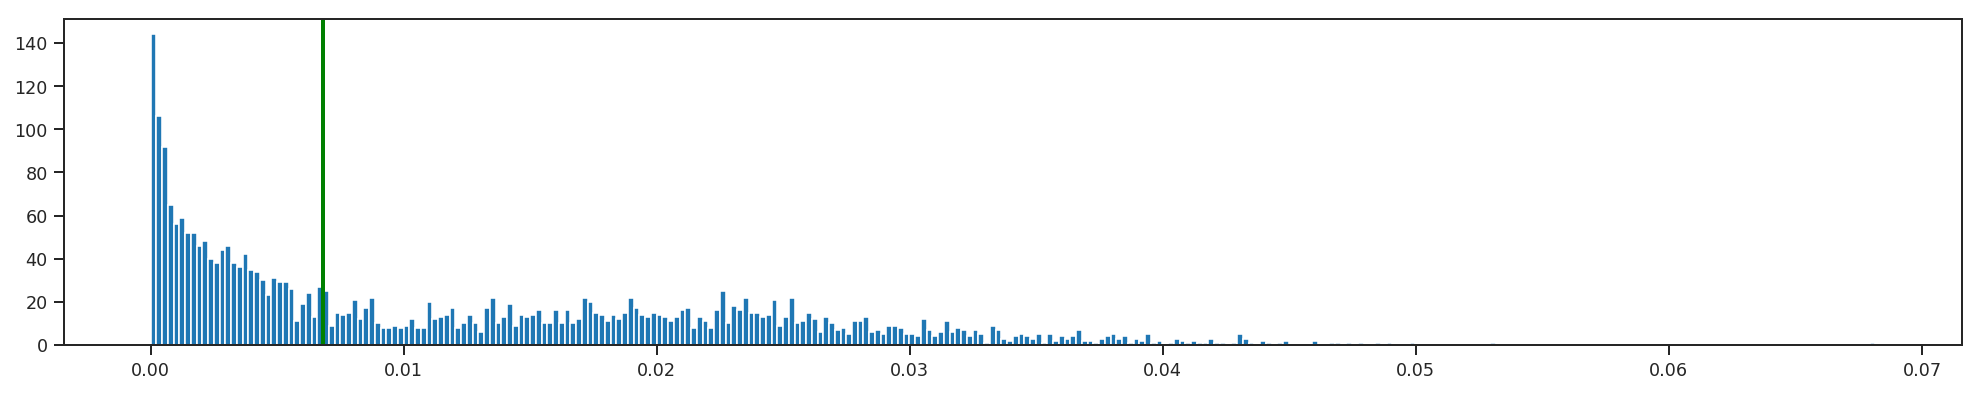

In [300]:
# For the longest exon, we use the 500+ distribution
exon_group_mpd_500plus_1 = get_mpd_by_coding_position(1, 500, None)
exon_group_mpd_500plus_2 = get_mpd_by_coding_position(2, 500, None)
exon_group_mpd_500plus_3 = get_mpd_by_coding_position(3, 500, None)

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus_1, bins = 300)
ax.axvline(dsx_exon_mean_mpd_1[3], color='green', lw = 2)
plt.show()

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus_3, bins = 300)
ax.axvline(dsx_exon_mean_mpd_2[3], color='green', lw = 2)
plt.show()

fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus_3, bins = 300)
ax.axvline(dsx_exon_mean_mpd_3[3], color='green', lw = 2)
plt.show()



In [302]:
# What proportion of the distributions is at least as small as that exon?
print('First coding position:')
print(np.sum(exon_group_mpd_500plus_1 <= np.mean(dsx_exon_mean_mpd_1[3])) / len(exon_group_mpd_500plus_1))

print('Second coding position:')
print(np.sum(exon_group_mpd_500plus_2 <= np.mean(dsx_exon_mean_mpd_2[3])) / len(exon_group_mpd_500plus_2))

print('Third coding position:')
print(np.sum(exon_group_mpd_500plus_3 <= np.mean(dsx_exon_mean_mpd_3[3])) / len(exon_group_mpd_500plus_3))

# Second coding position is significant here


First coding position:
0.10089841050449205
Second coding position:
0.015549412577747062
Third coding position:
0.4612992398064962


In [235]:
pd.DataFrame(np.array(etl.search(tbl_introns, 'AGAP004050')))


,0,1,2,3,4,5,6,7,8
0,seqid,type,start,stop,length,strand,parent,first,last
1,2R,intron,48714648,48715160,512,-,AGAP004050-RA,False,True
2,2R,intron,48715295,48747692,32397,-,AGAP004050-RA,False,False
3,2R,intron,48747737,48784184,36447,-,AGAP004050-RA,True,False


In [237]:
pd.DataFrame(np.array(etl.search(tbl_cdss, 'AGAP004050')))


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID,first,last
1,2R,VectorBase,CDS,48714556,48714648,92,.,-,2,AGAP004050-RA,AGAP004050-PA,False,True
2,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RA,AGAP004050-PA,True,False
3,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RA,AGAP004050-PA,False,True
4,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RA,AGAP004050-PA,True,False


In [236]:
pd.DataFrame(np.array(etl.search(tbl_features, 'AGAP004050').eq('type', 'CDS')))

,0,1,2,3,4,5,6,7,8,9,10
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID
1,2R,VectorBase,CDS,48711598,48712794,1196,.,-,2,AGAP004050-RB,AGAP004050-PB
2,2R,VectorBase,CDS,48714556,48714648,92,.,-,2,AGAP004050-RA,AGAP004050-PA
3,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RA,AGAP004050-PA
4,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RB,AGAP004050-PB
5,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RA,AGAP004050-PA
6,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RB,AGAP004050-PB
7,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RA,AGAP004050-PA
8,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RB,AGAP004050-PB


In [240]:
pd.DataFrame(np.array(etl.search(tbl_features, 'AGAP004050')))

,0,1,2,3,4,5,6,7,8,9,10
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID
1,2R,VectorBase,exon,48703663,48706331,2668,.,-,.,AGAP004050-RB,None
2,2R,VectorBase,three_prime_UTR,48703663,48706331,2668,.,-,.,AGAP004050-RB,None
3,2R,VectorBase,gene,48703663,48788460,84797,.,-,.,None,AGAP004050
4,2R,VectorBase,mRNA,48703663,48788460,84797,.,-,.,AGAP004050,AGAP004050-RB
5,2R,VectorBase,three_prime_UTR,48711527,48711598,71,.,-,.,AGAP004050-RB,None
6,2R,VectorBase,exon,48711527,48712794,1267,.,-,.,AGAP004050-RB,None
7,2R,VectorBase,CDS,48711598,48712794,1196,.,-,2,AGAP004050-RB,AGAP004050-PB
8,2R,VectorBase,three_prime_UTR,48712936,48714556,1620,.,-,.,AGAP004050-RA,None
9,2R,VectorBase,exon,48712936,48714648,1712,.,-,.,AGAP004050-RA,None


/home/eric/Manuscripts/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


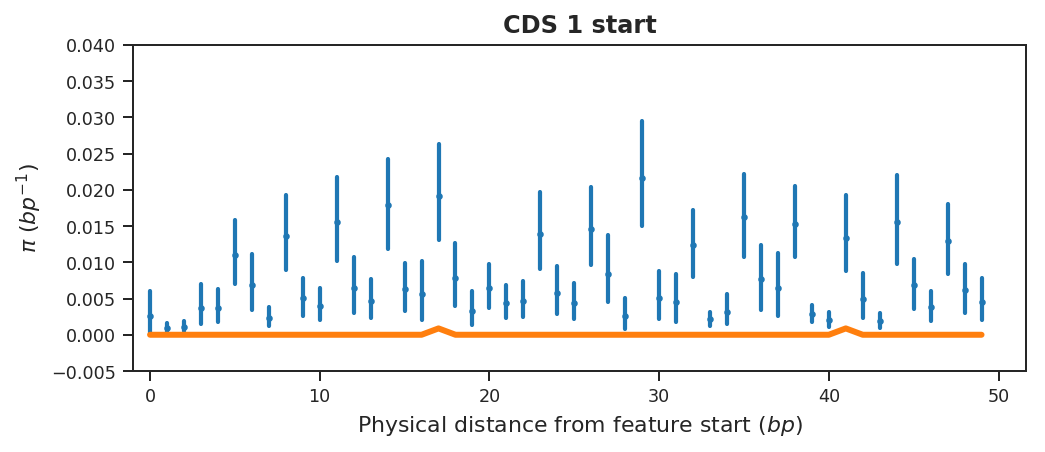

In [454]:
# Right, now let's make a plot of of whole gene, showing the first and last 50bp of each feature.
# We will not include the UTRs, just the exons and introns. Since the gene is in the reverse reading
# frame, the start point of the exon is its "end point" as far as genomic coordinates are concerned.

# First CDS:
def plot_cds_1_start(cds_start = dsx_exon_end_pos[3], bp_lim = 50):
    # Since the gene is in the reverse reading frame, the first 50bp of the cds are BEFORE the start
    # point in therms of genomic coordinates
    target_range = range(cds_start-bp_lim, cds_start)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    cls = [CLS_EXON_FIRST]
    y_min = -0.005
    y_max = 0.04
    min_flen = 500
    max_flen = np.inf

    # obtain variables
    flt = np.isin(seq_cls, cls) & (seq_relpos < bp_lim) & (seq_flen >= min_flen) & (seq_flen <= max_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(bp_lim), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_xlim(left=-1)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 1 start'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()


plot_cds_1_start()

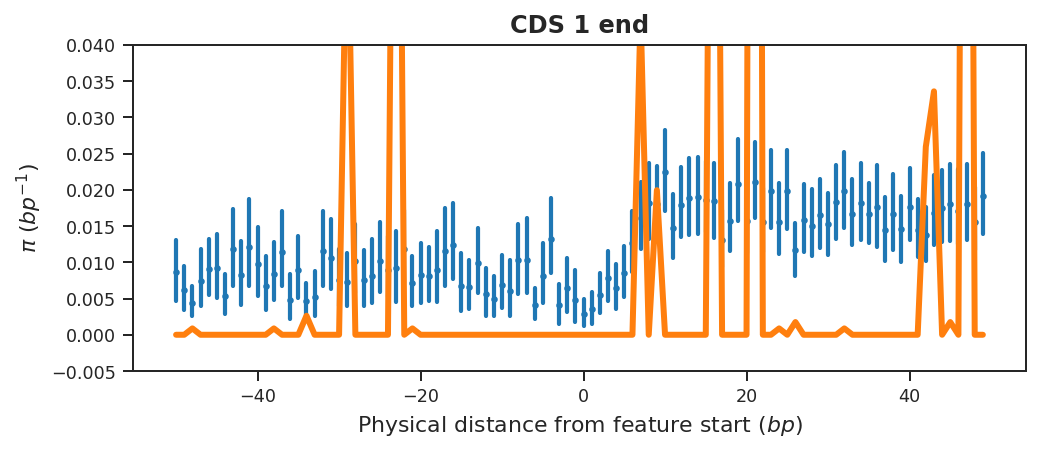

In [455]:
# End of cds 1
def plot_cds_1_end(cds_end = dsx_exon_start_pos[3], bp_lim = 50):
    target_range = range(cds_end-bp_lim, cds_end+bp_lim)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    cds_cls = [CLS_EXON_FIRST]
    intron_cls = [CLS_INTRON_FIRST]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 500
    max_cds_flen = np.inf
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = -(1+seq_relpos_end[cds_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    cds_values = seq_mpd[cds_flt]
    intron_dist = seq_relpos[intron_flt].astype('int')
    intron_values = seq_mpd[intron_flt]
    dist = np.concatenate([cds_dist, intron_dist])
    values = np.concatenate([cds_values, intron_values])
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,bp_lim), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(-bp_lim,bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 1 end'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_1_end()

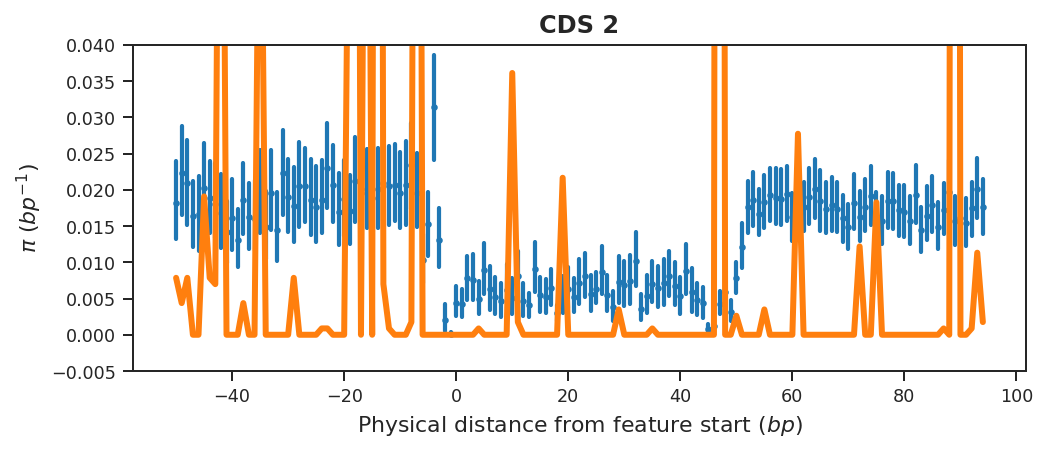

In [456]:
# cds 2 is only 45 bp long, so we encompass it all in a single plot, along with the introns either side
def plot_cds_2(cds_start = dsx_exon_end_pos[2], cds_end = dsx_exon_start_pos[2], bp_lim = 50):
    target_range = range(cds_end-bp_lim, cds_start+bp_lim)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
        
    cds_cls = [CLS_EXON_MID]
    # The end of the intron we are showing is the first intron, but the start is the second intron
    intron_end_cls = [CLS_INTRON_FIRST]
    intron_start_cls = [CLS_INTRON_MID]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 0
    max_cds_flen = 100
    min_intron_flen = 300

    # Find the midpoint of the CDS region (before this point, we will compare with the chromosome average
    # relative to cds start points, after the midpoint, we will compare with the chromosome average relative
    # to the cds end points).
    cds_len = cds_start - cds_end
    cds_midpoint = cds_len//2
    cds_start_flt = np.isin(seq_cls, cds_cls) & (seq_relpos < cds_midpoint) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    cds_end_flt = np.isin(seq_cls, cds_cls) & (seq_relpos_end < (cds_len - cds_midpoint)) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_end_flt = np.isin(seq_cls, intron_end_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    intron_start_flt = np.isin(seq_cls, intron_start_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_intron_flen)
    cds_start_dist = seq_relpos[cds_start_flt].astype('int')
    cds_end_dist = -(1+seq_relpos_end[cds_end_flt].astype('int')) + cds_len # Need to change dtype here because can't take a negative of unsigned integer
    cds_start_values = seq_mpd[cds_start_flt]
    cds_end_values = seq_mpd[cds_end_flt]
    intron_end_dist = -(1+seq_relpos_end[intron_end_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_end_values = seq_mpd[intron_end_flt]
    intron_start_dist = seq_relpos[intron_start_flt].astype('int') + cds_len
    intron_start_values = seq_mpd[intron_start_flt]
    dist = np.concatenate([intron_end_dist, cds_start_dist, cds_end_dist, intron_start_dist])
    values = np.concatenate([intron_end_values, cds_start_values, cds_end_values, intron_start_values])
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,len(target_mpd)-bp_lim), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(-bp_lim,len(target_mpd)-bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 2'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_2()


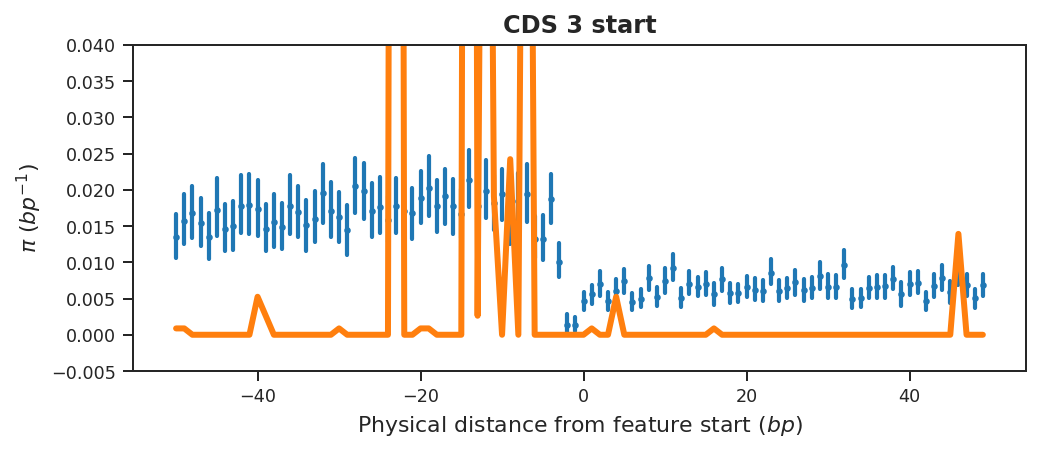

In [457]:
# Start of cds 3
def plot_cds_3_start(cds_start = dsx_exon_end_pos[1], bp_lim = 50):
    target_range = range(cds_start-bp_lim, cds_start+bp_lim)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    cds_cls = [CLS_EXON_MID]
    intron_cls = [CLS_INTRON_MID]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 100
    max_cds_flen = 200
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = seq_relpos[cds_flt].astype('int')
    cds_values = seq_mpd[cds_flt]
    intron_dist = -(1+seq_relpos_end[intron_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_values = seq_mpd[intron_flt]
    dist = np.concatenate([intron_dist, cds_dist])
    values = np.concatenate([intron_values, cds_values])
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,bp_lim), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(-bp_lim,bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 3 start'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_3_start()

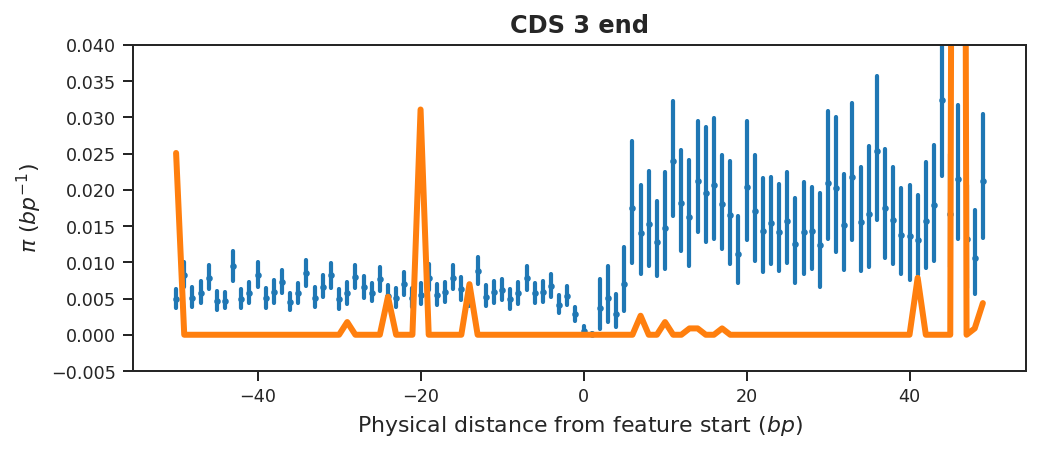

In [459]:
# End of cds3
def plot_cds_3_end(cds_end = dsx_exon_start_pos[1], bp_lim = 50):
    target_range = range(cds_end-bp_lim, cds_end+bp_lim)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    cds_cls = [CLS_EXON_MID]
    intron_cls = [CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 100
    max_cds_flen = 200
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = -(1+seq_relpos_end[cds_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    cds_values = seq_mpd[cds_flt]
    intron_dist = seq_relpos[intron_flt].astype('int')
    intron_values = seq_mpd[intron_flt]
    dist = np.concatenate([cds_dist, intron_dist])
    values = np.concatenate([cds_values, intron_values])
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,bp_lim), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(-bp_lim,bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 3 end'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_3_end()

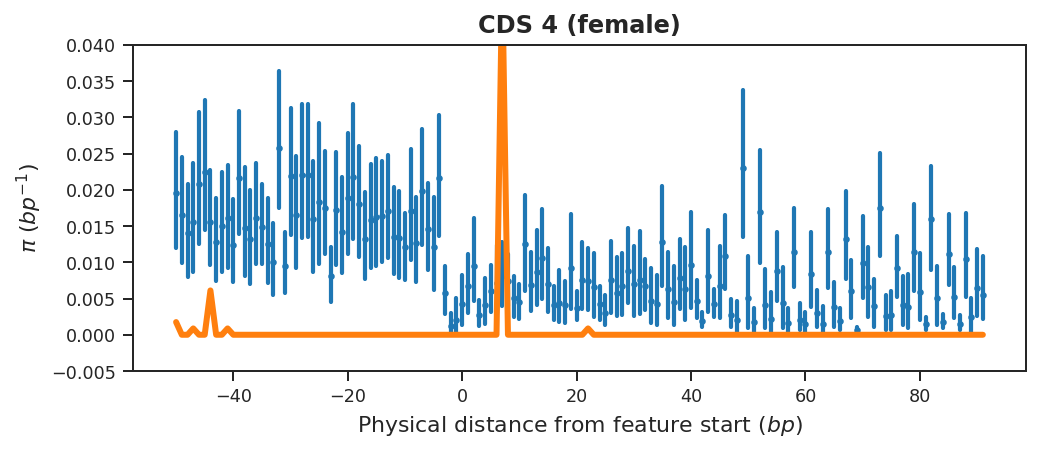

In [460]:
# female cds 4 is only 92 bp long, so we encompass it all in a single plot, along with the intron
# upstream.
def plot_cds_4f(cds_start = dsx_exon_end_pos[0], cds_end = dsx_exon_start_pos[0], bp_lim = 50):
    target_range = range(cds_end, cds_start+bp_lim)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
        
    cds_cls = [CLS_EXON_LAST]
    intron_cls = [CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 0
    max_cds_flen = 100
    min_intron_flen = 300

    # Find the midpoint of the CDS region (before this point, we will compare with the chromosome average
    # relative to cds start points, after the midpoint, we will compare with the chromosome average relative
    # to the cds end points).
    cds_len = cds_start - cds_end
    cds_midpoint = cds_len//2
    cds_start_flt = np.isin(seq_cls, cds_cls) & (seq_relpos < cds_midpoint) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    cds_end_flt = np.isin(seq_cls, cds_cls) & (seq_relpos_end < (cds_len - cds_midpoint)) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_end_flt = np.isin(seq_cls, intron_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    cds_start_dist = seq_relpos[cds_start_flt].astype('int')
    cds_end_dist = -(1+seq_relpos_end[cds_end_flt].astype('int')) + cds_len # Need to change dtype here because can't take a negative of unsigned integer
    cds_start_values = seq_mpd[cds_start_flt]
    cds_end_values = seq_mpd[cds_end_flt]
    intron_end_dist = -(1+seq_relpos_end[intron_end_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_end_values = seq_mpd[intron_end_flt]
    dist = np.concatenate([intron_end_dist, cds_start_dist, cds_end_dist])
    values = np.concatenate([intron_end_values, cds_start_values, cds_end_values])
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,len(target_mpd)-bp_lim), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(-bp_lim,len(target_mpd)-bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 4 (female)'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_4f()

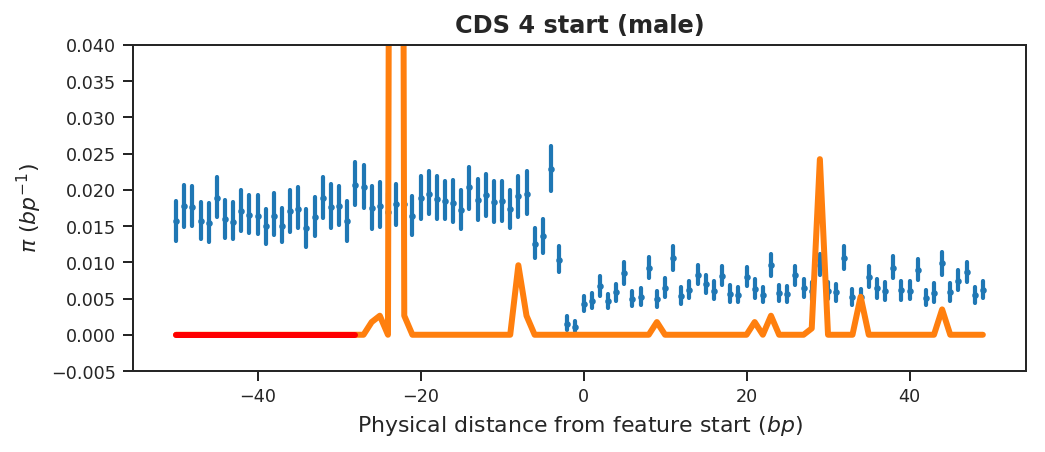

In [453]:
# Male cds is longer, so plot the start and end of it separately
# To be consistent with earlier object naming, we use "start" and "end" to refer to genomic 
# coordinates, rather than transcription direction (so the "start" is the end of the reading
# frame)
dsx_exon_4m_start = 48711598
dsx_exon_4m_end = 48712794
def plot_cds_4m_start(cds_start = dsx_exon_4m_end, bp_lim = 50):
    target_range = range(cds_start-bp_lim, cds_start+bp_lim)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    intron_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 100
    max_cds_flen = 200
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = seq_relpos[cds_flt].astype('int')
    cds_values = seq_mpd[cds_flt]
    intron_dist = -(1+seq_relpos_end[intron_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_values = seq_mpd[intron_flt]
    dist = np.concatenate([intron_dist, cds_dist])
    values = np.concatenate([intron_values, cds_values])
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,bp_lim), target_mpd[::-1], lw=3)
    # There is only one inaccessible stretch in this region, so we can show it thusly
    ax.plot(np.array(range(-bp_lim,bp_lim))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 4 start (male)'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_4m_start()

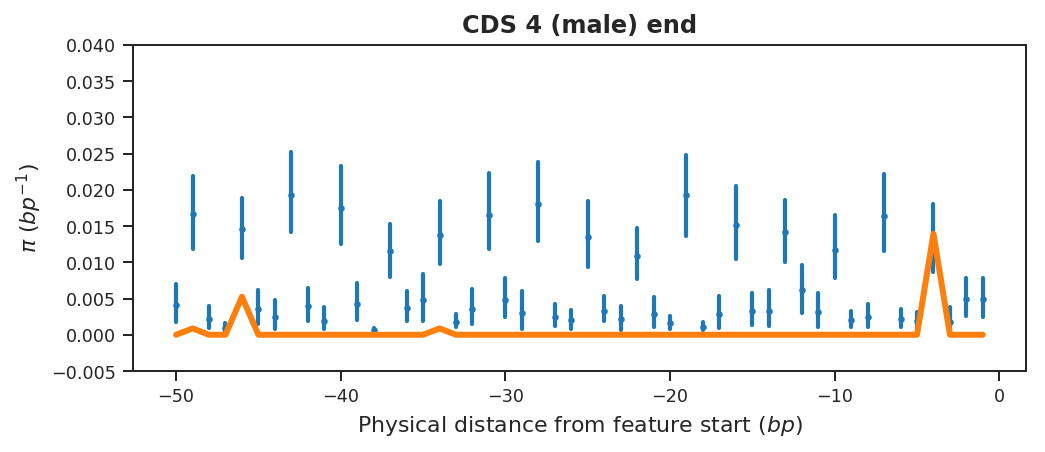

In [461]:
# And now the end of the male version of cds 4
def plot_cds_4m_end(cds_end = dsx_exon_end_pos[1], bp_lim = 50):
    target_range = range(cds_end-bp_lim, cds_end)
    target_acc = accessibility[chrom]['is_accessible'][target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    cds_cls = [CLS_EXON_LAST]
    y_min = -0.005
    y_max = 0.04
    min_cds_flen = 100
    max_cds_flen = 200

    # obtain variables
    flt = np.isin(seq_cls, cds_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    dist = -(1+seq_relpos_end[flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    values = seq_mpd[flt]
    
    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(-bp_lim,0), target_mpd[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.plot(np.array(range(-bp_lim,0))[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=3, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 4 (male) end'
    ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

plot_cds_4m_end()

In [439]:
dsx_exon_end_pos[1]

48715295

In [320]:
np.concatenate([seq_mpd[20:30], -seq_mpd[30:40]])

array([ 0.        ,  0.04287985,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        , -0.        , -0.00262697, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ])